# DEEP LEARNING MODEL FOR PREDICTING THE TSUNAMI WAVE HEIGHT AND ARRIVAL TIME ON BALI ISLAND
# *******************************************************************************************
## COPYRIGHT © 2023 AUTHOR : AKHMAD IQBAL IKROMI
### Institut Teknologi Bandung, iqbalikromi@gmail.com


In [1]:
# Importing the libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from keras.utils import plot_model
from scipy.signal import find_peaks
import keras_tuner as kt
import seaborn as sns
import warnings
import time
import csv

# 1. HELPER FUNCTION SETTING

In [2]:
#helper function untuk prediksi
def locate(loc):
    if loc == 'A':
        location = [1, 0, 0, 0, 0, 0]
        A = 1 
        B,C,D,E,F = 0,0,0,0,0
    elif loc == 'B':
        location = [0, 1, 0, 0, 0, 0]
        B = 1
        A,C,D,E,F = 0,0,0,0,0
    elif loc == 'C':
        location = [0, 0, 1, 0, 0, 0]
        C = 1
        A,B,D,E,F = 0,0,0,0,0
    elif loc == 'D':
        location = [0, 0, 0, 1, 0, 0]
        D = 1
        A,B,C,E,F = 0,0,0,0,0
    elif loc == 'E':
        location = [0, 0, 0, 0, 1, 0]
        E = 1
        A,B,C,D,F = 0,0,0,0,0
    elif loc == 'F':
        location = [0, 0, 0, 0, 0, 1]
        F = 1
        A,B,C,D,E = 0,0,0,0,0
    return A,B,C,D,E,F

def csv(filename):
    data = []
    a = pd.read_csv(filename)
    b = tf.convert_to_tensor(a["water level (m)"].values, dtype=tf.float64)
    data = np.array(b)
    return data

def time_plot(files):
    trv = []
    for file in files:
        trv.append(csv(file))
    trv_arr = np.array(trv)
    ott2 = pd.DataFrame(trv_arr)
    ott = ott2.iloc[:,:120]
    time_plot = ott.transpose()
    col_name = np.arange(7, 9.1, 0.1)
    col_name = np.round(col_name,1)
    time_plot.columns = col_name
    return time_plot

def set_input(Mw_awal, intv):
    data_Mw = np.arange(Mw_awal, 9.1, intv)
    data_Mw = np.round(data_Mw,1)
    index_data = np.tile(data_Mw,6)
    Mw_reshape= data_Mw.reshape(-1,1).flatten()

    # Normalize data
    #Mw_norm = scaler.transform(Mw_reshape).flatten()
    Mw_data = np.tile(Mw_reshape,6)
    mwt = pd.DataFrame({'Mw':Mw_data})
    #mwt.index = index_train
    shape = len(data_Mw)
    mwA = [1]*shape + [0]*(shape*5)
    mwB = [0]*shape + [1]*shape + [0]*(shape*4)
    mwC = [0]*(shape*2) + [1]*shape + [0]*(shape*3)
    mwD = [0]*(shape*3) + [1]*shape + [0]*(shape*2)
    mwE = [0]*(shape*4) + [1]*shape + [0]*(shape*1)
    mwF = [0]*(shape*5) + [1]*shape 
    MWA = pd.DataFrame({'A':mwA})
    MWB = pd.DataFrame({'B':mwB})
    MWC = pd.DataFrame({'C':mwC})
    MWD = pd.DataFrame({'D':mwD})
    MWE = pd.DataFrame({'E':mwE})
    MWF = pd.DataFrame({'F':mwF})
    data = pd.concat([mwt, MWA,MWB,MWC,MWD, MWE, MWF], axis=1)
    #data_norm = normalizer(np.array(data)).numpy()
    #datainput = pd.DataFrame(data_norm)
    data.index = index_data
    return data


def r_square(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred)) 
    SS_tot = np.sum(np.square(y_true - np.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot ) )

def rmse_val(data, pred):
    rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    rmse_metric.update_state(pred,data)
    rmse_value1 =rmse_metric.result().numpy()
    return rmse_value1


def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

def time_plot(files):
    trv = []
    for file in files:
        trv.append(csv(file))
    #trv_arr = np.array(trv)
    #trv_arr[:, :15][(trv_arr[:, :15] > -0.01) & (trv_arr[:, :15] < 0.01)] = 0.001    
    ott2 = pd.DataFrame(trv)
    ott = ott2.iloc[:,:120]
    time_plot = ott.transpose()
    col_name = np.arange(7, 9.1, 0.1)
    col_name = np.round(col_name,1)
    time_plot.columns = col_name
    return time_plot

def filecsv_name(loc,code):
    loc = loc
    code = code
    dat = str(loc) + str(code)
    filename = [str(loc) + str(code) + 'Mw{}'.format(i) + '.csv' for i in range(70, 91)]
    return filename

def import_file(code):
    A = filecsv_name('A',code)
    B = filecsv_name('B',code)
    C = filecsv_name('C',code)
    D = filecsv_name('D',code)
    E = filecsv_name('E',code)
    F = filecsv_name('F',code)
    return A,B,C,D,E,F
def caridata(p1,loc):
    A,B,C,D,E,F=locate(loc)
    data = np.array(p1[(p1['A'] == A) & (p1['B']==B) & (p1['C']==C)&
                          (p1['D']==D) & (p1['E']==E) & (p1['F']==F)])
    data = data[:,7:].transpose()
    return data
def code_pantai(pantai):
    if pantai == 'tanahlot':
        jpantai = data_tanahlot
        pt = 0
        name = 'Tanah Lot'
    elif pantai == 'kuta':
        jpantai = data_kuta
        pt = 1
        name = 'Kuta'
    elif pantai == 'uluwatu':
        jpantai = data_uluwatu
        pt = 2
        name = 'Uluwatu'
    elif pantai == 'nusadua':
        jpantai = data_nusadua
        pt = 3
        name = 'Nusa Dua'
    elif pantai == 'sanur':
        jpantai = data_sanur
        pt = 4
        name = 'Sanur'
    elif pantai == 'kelingking':
        jpantai = data_kelingking
        pt = 5  
        name = 'Kelingking'
    return jpantai, pt, name
    

def import_csv(code):
    A,B,C,D,E,F = import_file(code)
    arrvA = time_plot(A)
    arrvB = time_plot(B)
    arrvC = time_plot(C)
    arrvD = time_plot(D)
    arrvE = time_plot(E)
    arrvF = time_plot(F)
    outdatabase2_data = pd.concat([arrvA.transpose(),arrvB.transpose(),
                        arrvC.transpose(),arrvD.transpose(),arrvE.transpose(),
                                  arrvF.transpose()]) 
    outdatabase2 = pd.concat([database, outdatabase2_data], axis=1)
    outtrans = outdatabase2.transpose()[7:]
    
    std = outtrans.describe().transpose()[['std']]
    mean = outtrans.describe().transpose()[['mean']]
    sanur_normalizer = tf.keras.layers.Normalization(axis=1)
    sanur_normalizer.adapt(outtrans)
    sanur = sanur_normalizer(outtrans)
    sanur = pd.DataFrame(sanur)
    index_data = outdatabase2.index
    return sanur, std, mean, index_data, outdatabase2
def data_prep(data):
    datas = data[0].transpose()
    std = data[1]
    mean = data[2]
    data_asli =data[4]
    datas.index = database.index
    data_pantai = pd.concat([database,datas], axis=1)
    stdev = pd.concat([database,std],axis=1)
    means = pd.concat([database,mean],axis=1)
    return data_pantai, stdev, means, data_asli

def prek(Mw_prediksi,loc,pantai):
    jpantai, pt, name = code_pantai(pantai)
    A1,B1,C1,D1,E1,F1=locate(loc)
    Mw = np.array([Mw_prediksi,A1,B1,C1,D1,E1,F1])
    Mw_to_predict = normalizer_input(Mw)
    #cari nilai standar deviasi dan mean
    st = jpantai[1].loc[Mw_prediksi]
    mn = jpantai[2].loc[Mw_prediksi]
    stdevdt = caridata(st,loc)
    meandt = caridata(mn,loc)
    import time
    start_time = time.time()
    preds = tsunami_bali2.predict(Mw_to_predict,verbose=10)
    end_time = time.time()
    time = end_time-start_time
    pred_norm = preds[pt].reshape(-1,1)
    pred = np.multiply(preds[pt],stdevdt)+meandt
    pred = pred.reshape(-1,1)

    p_asli = jpantai[3].loc[Mw_prediksi]
    Mws,A,B,C,D,E,F = np.array(Mw_to_predict).reshape(-1)
    data = caridata(p_asli,loc)
    return pred, data, time
 
def plot_prediksi(Mw_pred, loc):
    predikawal(Mw_pred,loc,'tanahlot')
    predikawal(Mw_pred,loc,'kuta')
    predikawal(Mw_pred,loc,'uluwatu')
    predikawal(Mw_pred,loc,'nusadua')
    predikawal(Mw_pred,loc,'sanur')
    predikawal(Mw_pred,loc,'kelingking')
    

def plot_r(loc,pantai):
    mws = np.round(np.arange(7,9.1,0.1),1)
    r2val = []
    rmseval= []
    for mw in mws:
            pred, data,time = prek(mw,loc,pantai)
            r2val.append(r_square(pred,data))
            rmseval.append(rmse_val(pred,data))
    fig, (ax1,ax2) = plt.subplots(2)
    fig.suptitle({pantai,loc})
    r_avg = np.mean(r2val)
    rmse_avg = np.mean(rmseval)
    print('$R^2$ average: ',r_avg)
    print('RMSE average: ',rmse_avg)
    ax1.plot(mws,r2val)
    ax1.set_ylim([0,1])
    ax2.plot(mws,rmseval)
    return plt.show()
def plot_r2(pantai):
    plot_r('A',pantai)
    plot_r('B',pantai)
    plot_r('C',pantai)
    plot_r('D',pantai)
    plot_r('E',pantai)
    plot_r('F',pantai) 

def predikawal(Mw_prediksi,loc,pantai):
    pred,data,time = prek(Mw_prediksi,loc,pantai)
    h=np.arange(0,120)
    r2 = r_square(pred,data)


    plt.subplot(2,1,1)
    plotting(data,pred, pantai, Mw_prediksi,time,loc)
    #plotting
    plt.subplot(2,2,1)
    plt.scatter(pred,data, c = "blue", s=5)
    plt.grid()

    plt.ylabel('Delft 3D (m)',**tnrfont)
    plt.xlabel('Prediksi (m)',**tnrfont)
    plt.title('$R^2$: {:.3f}'.format(r2),**tnrfont)
    lims = [min(np.amin(pred)*1.5,np.amin(data)),
            max(np.amax(pred), np.amax(data))*1.5]
    _ = plt.plot(lims,lims,color='red', lw=1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal')
    plt.show()
    plt.close()
    return


def max_height(x,y,ar):
    yk = y[ar:ar+20]
    max_index = np.argmax(y)

    x_max = x[max_index]
    y_max = y[max_index]
    xm = np.array(x_max)
    ym = np.array(y_max)
    return xm,ym

def tsunami_parameter(loc,pantai):
    mws = np.round(np.arange(7,9.1,0.1),1)
    h = np.arange(0,120)
    maxh_pred = []
    maxh_data = []
    arrtime_pred= []
    arrtime_data= []
    for mw in mws:
            pred, data,time = prek(mw,loc,pantai)
            ar_pred, ar_y = arrivaltime(h,pred, pantai)
            ar_data, ar_y2 = arrivaltime(h,data, pantai)
            xpred, maxpred = max_height(h,pred,ar_pred)
            xdata, maxdata = max_height(h,data,ar_data)          
            maxh_pred.append(maxpred)
            maxh_data.append(maxdata)
            arrtime_pred.append(ar_pred)
            arrtime_data.append(ar_data)
    maxh_data = np.array(maxh_data).reshape(-1)
    maxh_pred = np.array(maxh_pred).reshape(-1)
    arrtime_pred = np.array(arrtime_pred).reshape(-1)
    arrtime_data = np.array(arrtime_data).reshape(-1)
    maxh = pd.concat([pd.DataFrame(maxh_data),pd.DataFrame(maxh_pred)], axis=1)
    maxh.index = mws
    maxh.columns = (['Numerik','Prediksi'])
    artm = pd.concat([pd.DataFrame(arrtime_data),pd.DataFrame(arrtime_pred)],
                         axis=1)
    artm.index = mws
    artm.columns = (['Numerik','Prediksi'])
    r2maxh = r_square(maxh_data,maxh_pred)
    r2arrtime = r_square(arrtime_data,arrtime_pred)
    return maxh, artm, r2maxh, r2arrtime
def korelasi_hasil(pantai):
    maxh_all = pd.DataFrame()
    artm_all = pd.DataFrame()
    locs = ('A','B','C','D','E','F')

    for lok in locs:
        maxh, artm, r2maxh, r2arrtime = tsunami_parameter(lok,pantai)
        maxh_all = pd.concat([maxh,maxh_all])
        artm_all  = pd.concat([artm,artm_all])
    r_maxh_all = r_square(maxh_all['Numerik'],maxh_all['Prediksi'])
    r_artm_all = r_square(artm_all['Numerik'],artm_all['Prediksi'])
    sns.lmplot(data=maxh_all, x='Numerik', y='Prediksi', 
               palette='Set1')
    plt.grid()
    nama = code_pantai(pantai)
    plt.title('Ketinggian Tsunami\n$R^2$: {:.3f}, Lokasi : {}'
              .format(r_maxh_all,nama[2]),**tnrfont, size=14)
    #plt.suptitle(nama[2],**tnrfont)
    plt.xlabel('Numerik',**tnrfont)
    plt.ylabel('Prediksi',**tnrfont)
    ######################################
    sns.lmplot(data=artm_all, x='Numerik', y='Prediksi', 
               palette='Set1')
    plt.grid()
    nama = code_pantai(pantai)
    plt.title('Waktu Kedatangan Tsunami\n$R^2$: {:.3f}, Lokasi : {}'
              .format(r_artm_all,nama[2]),**tnrfont, size=14)
    #plt.suptitle(nama[2],**tnrfont)
    plt.xlabel('Numerik',**tnrfont)
    plt.ylabel('Prediksi',**tnrfont)

def plotting(pred, data, pantai, Mw_prediksi,time,loc):
    h = np.arange(0,120)
    rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    rmse_metric.update_state(pred,data)
    rmse_value1 =rmse_metric.result().numpy()

    #arrival time tsunami
    ar_pred, ar_y = arrivaltime(h,pred,pantai)
    ar_data, ar_y2 = arrivaltime(h,data,pantai)
    xpred, maxpred = max_height(h,pred,ar_pred)
    xdata, maxdata = max_height(h,data,ar_data)

    #plot
    plt.plot(h,pred, color='green',alpha=0.65, lw=1.5)
    plt.axvline(ar_pred, lw=2,linestyle='-',color='yellow')


    plt.plot(h,data, color='red', alpha=0.75 ,linestyle='--', lw=1.5)
    plt.axvline(ar_data,linestyle='-.' ,lw=1, color='blue')

    plt.scatter(xpred,pred[xpred],marker="o", s=35, color='orange')
    plt.scatter(xdata,data[xdata],marker="x", s=55, color='black')

    plt.grid()
    plt.xlabel('Waktu (menit)',**tnrfont)
    plt.ylabel('Ketinggian Tsunami (m)',**tnrfont)
    #Plotting
    plt.xlim(0,120)
    minval1=min(min(pred),min(data))
    maxval1=max(max(pred), max(data))
    plt.ylim(minval1+minval1/5, maxval1+maxval1/5)
    #plt.ylim(-2.5,2.5)

    plt.legend(['Delft3D (target)','Arrival time target','DL (Prediksi)'
               ,'Arrival time prediksi','Max H prediksi', 'Max H target'],
               fontsize=6,ncol=3, loc=8)
    plt.suptitle(code_pantai(pantai)[2], fontsize=20,**tnrfont)
    plt.title('{:.2f} Mw \nFault loc: {}'.format(Mw_prediksi,loc),loc='left',**tnrfont)
    plt.title("Prediction time: {:.4f} s".format(time),loc='right',**tnrfont,
             fontstyle="italic")
    plt.show()
    return
def arrivaltime(h,y_data, pantai):
    x = h
    y = np.array(y_data).reshape(-1)
    ysanur = y[:38] 
    ytanahlot = y[:42] 
    maxh = np.amax(y)
    if pantai == 'sanur':
        x_drop = ysanur.argmax()
    elif pantai == 'tanahlot':
        x_drop= ytanahlot.argmax()
    else:
        if maxh > 1:
            pr = 0.1
        elif maxh<=1:
            pr=0.02
        peaks, _ = find_peaks(y, height=0.02, prominence=pr)
        t = np.amax(y[peaks[0]])
        index = np.where(y==t)

        x_drop = index[0][0]
    return x_drop, x_drop



tnrfont = {'fontname':'Times New Roman'}

# 2. INPUT LAYER
## VARIASI MOMENT MAGNITUDE (Mw)

In [3]:
data_Mw = np.arange(7, 9.1, 0.1)
data_Mw = np.round(data_Mw,1)
index_data = np.tile(data_Mw,6)
database = set_input(7,0.1)
normalizer_input = tf.keras.layers.Normalization(axis=1)
normalizer_input.adapt(database)
xdatabase = normalizer_input(database)
xdatabase = pd.DataFrame(xdatabase)
xdatabase.index = database.index
#std = database.describe().transpose()[['std']]
#mean = database.describe().transpose()[['mean']]
#std = np.array(std)
#mean = np.array(mean)

# 3. SETTING OUTPUT
## CSV FILES HASIL RUNNING DELFT 3D

In [4]:
sanur_data = import_csv(7)
uluwatu_data = import_csv(5)
tanahlot_data = import_csv(1)
kuta_data = import_csv(4)
nusadua_data = import_csv(6)
kelingking_data = import_csv(11)

In [5]:
data_tanahlot = data_prep(tanahlot_data)
data_kuta = data_prep(kuta_data)
data_uluwatu = data_prep(uluwatu_data)
data_nusadua = data_prep(nusadua_data)
data_sanur = data_prep(sanur_data)
data_kelingking = data_prep(kelingking_data)

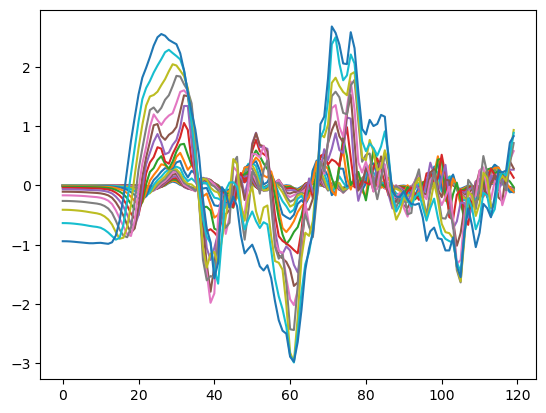

In [6]:
#----------DATA INSPECTION--------
#normal = y_train4
#DATA ASLI PANTAI
asli = np.array(data_sanur[3].transpose().iloc[7:].transpose())
g = np.arange(0,120)
a =np.arange(0,21,1)
b = np.arange(21,42,1)
c = np.arange(42,63,1)
d = np.arange(63,84,1)
e = np.arange(84,105,1)
b = np.arange(106,121,1)

#LOKASI FAULT
spc = c
#plt.plot(g,f)
for i in spc:
    plt.plot(g,asli[i])

# 4. SETTING DEEP LEARNING MODEL


In [7]:
#INDEXING
genap = np.arange(7, 9.1, 0.2)
genap = np.round(genap,1)
gnp = genap.tolist()

ganjil = np.arange(7.1, 9.1, 0.2)
ganjil = np.round(ganjil,1)
gjl = ganjil.tolist()

#menentukan test on training (control validation step)
test = [7.1,7.9, 8.5]

#setting train and test data
x_test =  xdatabase.transpose()[test].transpose()
x_train = xdatabase.transpose()[gnp].transpose()

y_test1 = data_tanahlot[0].transpose()[test].iloc[7:][test].transpose()
y_train1 = data_tanahlot[0].transpose()[gnp].iloc[7:].transpose()

y_test2 = data_kuta[0].transpose()[test].iloc[7:][test].transpose()
y_train2 = data_kuta[0].transpose()[gnp].iloc[7:].transpose()

y_test3 = data_uluwatu[0].transpose()[test].iloc[7:][test].transpose()
y_train3 = data_uluwatu[0].transpose()[gnp].iloc[7:].transpose()

y_test4 = data_nusadua[0].transpose()[test].iloc[7:][test].transpose()
y_train4 = data_nusadua[0].transpose()[gnp].iloc[7:].transpose()

y_test5 = data_sanur[0].transpose()[test].iloc[7:][test].transpose()
y_train5 = data_sanur[0].transpose()[gnp].iloc[7:].transpose()

y_test6 = data_kelingking[0].transpose()[test].iloc[7:][test].transpose()
y_train6 = data_kelingking[0].transpose()[gnp].iloc[7:].transpose()

input_shape = len(x_train.columns)
output1_shape = len(y_train1.columns)
output2_shape = len(y_train2.columns)
output3_shape = len(y_train3.columns)
output4_shape = len(y_train4.columns)
output5_shape = len(y_train5.columns)
output6_shape = len(y_train6.columns)

x_train.shape, y_train1.shape, y_train2.shape, y_train3.shape, y_train4.shape, y_train5.shape,y_train6.shape

((66, 7), (66, 120), (66, 120), (66, 120), (66, 120), (66, 120), (66, 120))

In [8]:
x_train

,0,1,2,3,4,5,6
7.0,-1.651446,2.236068,-0.447214,-0.447214,-0.447214,-0.447214,-0.447214
7.0,-1.651446,-0.447214,2.236068,-0.447214,-0.447214,-0.447214,-0.447214
7.0,-1.651446,-0.447214,-0.447214,2.236068,-0.447214,-0.447214,-0.447214
7.0,-1.651446,-0.447214,-0.447214,-0.447214,2.236068,-0.447214,-0.447214
7.0,-1.651446,-0.447214,-0.447214,-0.447214,-0.447214,2.236068,-0.447214
...,...,...,...,...,...,...,...
9.0,1.651446,-0.447214,2.236068,-0.447214,-0.447214,-0.447214,-0.447214
9.0,1.651446,-0.447214,-0.447214,2.236068,-0.447214,-0.447214,-0.447214
9.0,1.651446,-0.447214,-0.447214,-0.447214,2.236068,-0.447214,-0.447214
9.0,1.651446,-0.447214,-0.447214,-0.447214,-0.447214,2.236068,-0.447214


In [10]:
# mengubah ke bentuk array
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)
y_train2 = np.array(y_train2)
y_test2 = np.array(y_test2)
y_train3 = np.array(y_train3)
y_test3 = np.array(y_test3)
y_train4 = np.array(y_train4)
y_test4 = np.array(y_test4)
y_train5 = np.array(y_train5)
y_test5 = np.array(y_test5)
y_train6 = np.array(y_train6)
y_test6 = np.array(y_test6)


In [12]:
x_train.shape

(66, 7)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 50)           400         ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 50)           400         ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 50)           400         ['input_1[0][0]']                
                                                                                              

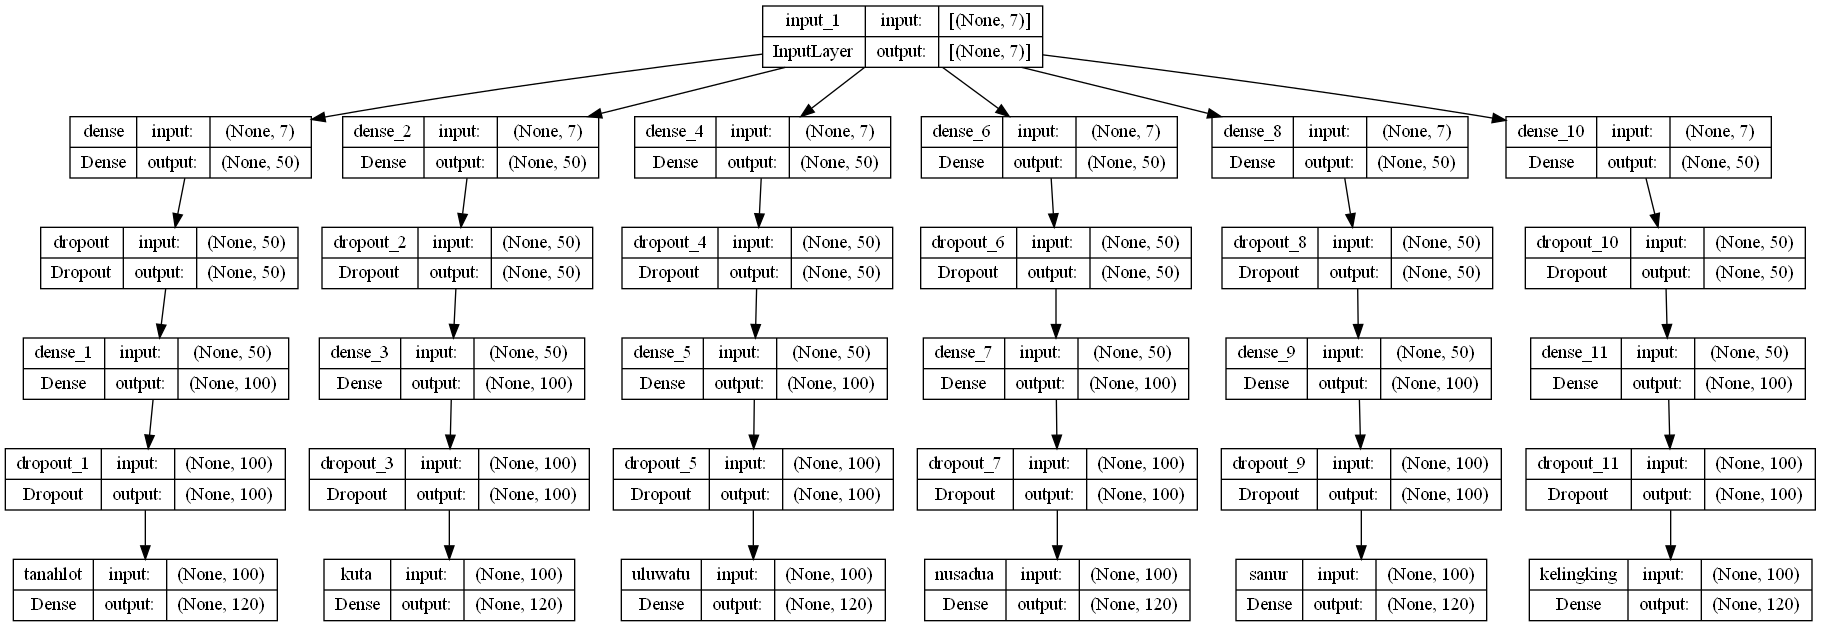

In [11]:
#input layer
inputs = keras.Input(shape=input_shape)
#output1
d1 = 50
d2 = 100
do = 0.1
hidden1a = keras.layers.Dense(d1, activation='relu')(inputs)
dropouta = Dropout(do)(hidden1a)

hidden2a = keras.layers.Dense(d2, activation='relu')(dropouta)
dropout2a = Dropout(do)(hidden2a)

outputs1 = keras.layers.Dense(output1_shape, name="tanahlot")(dropout2a)

#output2
hidden1b = keras.layers.Dense(d1, activation='relu')(inputs)
dropoutb = Dropout(do)(hidden1b)

hidden2b = keras.layers.Dense(d2, activation='relu')(dropoutb)
dropout2b = Dropout(do)(hidden2b)

outputs2 = keras.layers.Dense(output2_shape, name="kuta")(dropout2b)

#output3
hidden1c = keras.layers.Dense(d1, activation='relu')(inputs)
dropoutc = Dropout(do)(hidden1c)

hidden2c = keras.layers.Dense(d2, activation='relu')(dropoutc)
dropout2c = Dropout(do)(hidden2c)

outputs3 = keras.layers.Dense(output3_shape, name="uluwatu")(dropout2c)


#output4
hidden1d = keras.layers.Dense(d1, activation='relu')(inputs)
dropoutd = Dropout(do)(hidden1d)

hidden2d = keras.layers.Dense(d2, activation='relu')(dropoutd)
dropout2d = Dropout(do)(hidden2d)

outputs4 = keras.layers.Dense(output4_shape, name="nusadua")(dropout2d)

#output5
hidden1e = keras.layers.Dense(d1, activation='relu')(inputs)
dropoute = Dropout(do)(hidden1e)

hidden2e = keras.layers.Dense(d2, activation='relu')(dropoute)
dropout2e = Dropout(do)(hidden2e)

outputs5 = keras.layers.Dense(output5_shape, name="sanur")(dropout2e)

#output6
hidden1f = keras.layers.Dense(d1, activation='relu')(inputs)
dropoutf = Dropout(do)(hidden1f)

hidden2f = keras.layers.Dense(d2, activation='relu')(dropoutf)
dropout2f = Dropout(do)(hidden2f)

outputs6 = keras.layers.Dense(output6_shape, name="kelingking")(dropout2f)                             

                              
#setting model
outputall = [outputs1,outputs2,outputs3,outputs4,outputs5,outputs6]
tsunami_bali2 = keras.Model(inputs = inputs, outputs = outputall)
tsunami_bali2.summary()


#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
tsunami_bali2.compile(optimizer=optimizer,
                         loss={'tanahlot':'mse', 
                              'kuta':'mse',
                               'uluwatu':'mse',
                              'nusadua':'mse',
                              'sanur':'mse',
                              'kelingking':'mse'},
                         metrics={'tanahlot':tf.keras.metrics.RootMeanSquaredError(), 
                              'kuta':tf.keras.metrics.RootMeanSquaredError(),
                                  'uluwatu':tf.keras.metrics.RootMeanSquaredError(),
                                  'nusadua':tf.keras.metrics.RootMeanSquaredError(),
                                 'sanur':tf.keras.metrics.RootMeanSquaredError(),
                                 'kelingking':tf.keras.metrics.RootMeanSquaredError()})

# generate a visualization of the model architecture
plot_model(tsunami_bali2, to_file='model.png', show_shapes=True)


In [12]:
tf.keras.backend.clear_session()

In [13]:
#Training Data
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
history = tsunami_bali2.fit(x_train,
                          [y_train1,y_train2,y_train3,y_train4,y_train5,y_train6],
                          epochs=1000,
                          verbose=1, 
                          batch_size=2,
                          shuffle=True,
                          validation_data=(x_test,[y_test1,y_test2,y_test3,y_test4,y_test5,y_test6]), 
                          callbacks=[stop_early])
#(x_test,[y_test1,y_test2,y_test3,y_test4,y_test5])

Epoch 1/1000
33/33 [==============================] - 2s 14ms/step - loss: 5.5453 - tanahlot_loss: 0.9110 - kuta_loss: 0.8782 - uluwatu_loss: 0.9650 - nusadua_loss: 0.9307 - sanur_loss: 0.9292 - kelingking_loss: 0.9312 - tanahlot_root_mean_squared_error: 0.9545 - kuta_root_mean_squared_error: 0.9371 - uluwatu_root_mean_squared_error: 0.9823 - nusadua_root_mean_squared_error: 0.9647 - sanur_root_mean_squared_error: 0.9640 - kelingking_root_mean_squared_error: 0.9650 - val_loss: 4.8222 - val_tanahlot_loss: 0.7882 - val_kuta_loss: 0.7345 - val_uluwatu_loss: 0.8541 - val_nusadua_loss: 0.8187 - val_sanur_loss: 0.8292 - val_kelingking_loss: 0.7975 - val_tanahlot_root_mean_squared_error: 0.8878 - val_kuta_root_mean_squared_error: 0.8570 - val_uluwatu_root_mean_squared_error: 0.9242 - val_nusadua_root_mean_squared_error: 0.9048 - val_sanur_root_mean_squared_error: 0.9106 - val_kelingking_root_mean_squared_error: 0.8931
Epoch 2/1000
33/33 [==============================] - 0s 4ms/step - loss: 4

Epoch 10/1000
33/33 [==============================] - 0s 4ms/step - loss: 2.1577 - tanahlot_loss: 0.3637 - kuta_loss: 0.2865 - uluwatu_loss: 0.4360 - nusadua_loss: 0.4105 - sanur_loss: 0.3391 - kelingking_loss: 0.3219 - tanahlot_root_mean_squared_error: 0.6031 - kuta_root_mean_squared_error: 0.5352 - uluwatu_root_mean_squared_error: 0.6603 - nusadua_root_mean_squared_error: 0.6407 - sanur_root_mean_squared_error: 0.5823 - kelingking_root_mean_squared_error: 0.5674 - val_loss: 2.0018 - val_tanahlot_loss: 0.3624 - val_kuta_loss: 0.2454 - val_uluwatu_loss: 0.4079 - val_nusadua_loss: 0.3930 - val_sanur_loss: 0.3135 - val_kelingking_loss: 0.2795 - val_tanahlot_root_mean_squared_error: 0.6020 - val_kuta_root_mean_squared_error: 0.4954 - val_uluwatu_root_mean_squared_error: 0.6386 - val_nusadua_root_mean_squared_error: 0.6269 - val_sanur_root_mean_squared_error: 0.5599 - val_kelingking_root_mean_squared_error: 0.5287
Epoch 11/1000
33/33 [==============================] - 0s 3ms/step - loss: 

Epoch 19/1000
33/33 [==============================] - 0s 4ms/step - loss: 1.6466 - tanahlot_loss: 0.2872 - kuta_loss: 0.1755 - uluwatu_loss: 0.3584 - nusadua_loss: 0.3193 - sanur_loss: 0.2629 - kelingking_loss: 0.2434 - tanahlot_root_mean_squared_error: 0.5359 - kuta_root_mean_squared_error: 0.4190 - uluwatu_root_mean_squared_error: 0.5986 - nusadua_root_mean_squared_error: 0.5650 - sanur_root_mean_squared_error: 0.5127 - kelingking_root_mean_squared_error: 0.4933 - val_loss: 1.4375 - val_tanahlot_loss: 0.2558 - val_kuta_loss: 0.1316 - val_uluwatu_loss: 0.3297 - val_nusadua_loss: 0.2909 - val_sanur_loss: 0.2284 - val_kelingking_loss: 0.2010 - val_tanahlot_root_mean_squared_error: 0.5058 - val_kuta_root_mean_squared_error: 0.3628 - val_uluwatu_root_mean_squared_error: 0.5742 - val_nusadua_root_mean_squared_error: 0.5394 - val_sanur_root_mean_squared_error: 0.4779 - val_kelingking_root_mean_squared_error: 0.4484
Epoch 20/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 28/1000
33/33 [==============================] - 0s 3ms/step - loss: 1.3808 - tanahlot_loss: 0.2441 - kuta_loss: 0.1394 - uluwatu_loss: 0.3148 - nusadua_loss: 0.2507 - sanur_loss: 0.2225 - kelingking_loss: 0.2094 - tanahlot_root_mean_squared_error: 0.4941 - kuta_root_mean_squared_error: 0.3733 - uluwatu_root_mean_squared_error: 0.5610 - nusadua_root_mean_squared_error: 0.5007 - sanur_root_mean_squared_error: 0.4717 - kelingking_root_mean_squared_error: 0.4576 - val_loss: 1.1268 - val_tanahlot_loss: 0.2035 - val_kuta_loss: 0.0970 - val_uluwatu_loss: 0.2717 - val_nusadua_loss: 0.2101 - val_sanur_loss: 0.1816 - val_kelingking_loss: 0.1628 - val_tanahlot_root_mean_squared_error: 0.4511 - val_kuta_root_mean_squared_error: 0.3115 - val_uluwatu_root_mean_squared_error: 0.5213 - val_nusadua_root_mean_squared_error: 0.4583 - val_sanur_root_mean_squared_error: 0.4262 - val_kelingking_root_mean_squared_error: 0.4035
Epoch 29/1000
33/33 [==============================] - 0s 3ms/step - loss: 

Epoch 37/1000
33/33 [==============================] - 0s 4ms/step - loss: 1.1910 - tanahlot_loss: 0.2081 - kuta_loss: 0.1193 - uluwatu_loss: 0.2775 - nusadua_loss: 0.2062 - sanur_loss: 0.2002 - kelingking_loss: 0.1797 - tanahlot_root_mean_squared_error: 0.4562 - kuta_root_mean_squared_error: 0.3453 - uluwatu_root_mean_squared_error: 0.5268 - nusadua_root_mean_squared_error: 0.4541 - sanur_root_mean_squared_error: 0.4475 - kelingking_root_mean_squared_error: 0.4239 - val_loss: 0.9320 - val_tanahlot_loss: 0.1635 - val_kuta_loss: 0.0757 - val_uluwatu_loss: 0.2341 - val_nusadua_loss: 0.1652 - val_sanur_loss: 0.1565 - val_kelingking_loss: 0.1370 - val_tanahlot_root_mean_squared_error: 0.4044 - val_kuta_root_mean_squared_error: 0.2752 - val_uluwatu_root_mean_squared_error: 0.4838 - val_nusadua_root_mean_squared_error: 0.4064 - val_sanur_root_mean_squared_error: 0.3956 - val_kelingking_root_mean_squared_error: 0.3701
Epoch 38/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 46/1000
33/33 [==============================] - 0s 4ms/step - loss: 1.0664 - tanahlot_loss: 0.1852 - kuta_loss: 0.1006 - uluwatu_loss: 0.2477 - nusadua_loss: 0.2001 - sanur_loss: 0.1836 - kelingking_loss: 0.1492 - tanahlot_root_mean_squared_error: 0.4303 - kuta_root_mean_squared_error: 0.3171 - uluwatu_root_mean_squared_error: 0.4977 - nusadua_root_mean_squared_error: 0.4474 - sanur_root_mean_squared_error: 0.4285 - kelingking_root_mean_squared_error: 0.3863 - val_loss: 0.8335 - val_tanahlot_loss: 0.1481 - val_kuta_loss: 0.0690 - val_uluwatu_loss: 0.2116 - val_nusadua_loss: 0.1428 - val_sanur_loss: 0.1416 - val_kelingking_loss: 0.1204 - val_tanahlot_root_mean_squared_error: 0.3848 - val_kuta_root_mean_squared_error: 0.2626 - val_uluwatu_root_mean_squared_error: 0.4600 - val_nusadua_root_mean_squared_error: 0.3780 - val_sanur_root_mean_squared_error: 0.3763 - val_kelingking_root_mean_squared_error: 0.3470
Epoch 47/1000
33/33 [==============================] - 0s 3ms/step - loss: 

Epoch 55/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.9753 - tanahlot_loss: 0.1728 - kuta_loss: 0.0785 - uluwatu_loss: 0.2332 - nusadua_loss: 0.1639 - sanur_loss: 0.1753 - kelingking_loss: 0.1516 - tanahlot_root_mean_squared_error: 0.4157 - kuta_root_mean_squared_error: 0.2801 - uluwatu_root_mean_squared_error: 0.4829 - nusadua_root_mean_squared_error: 0.4048 - sanur_root_mean_squared_error: 0.4187 - kelingking_root_mean_squared_error: 0.3894 - val_loss: 0.7747 - val_tanahlot_loss: 0.1337 - val_kuta_loss: 0.0619 - val_uluwatu_loss: 0.1918 - val_nusadua_loss: 0.1342 - val_sanur_loss: 0.1401 - val_kelingking_loss: 0.1129 - val_tanahlot_root_mean_squared_error: 0.3657 - val_kuta_root_mean_squared_error: 0.2489 - val_uluwatu_root_mean_squared_error: 0.4380 - val_nusadua_root_mean_squared_error: 0.3663 - val_sanur_root_mean_squared_error: 0.3743 - val_kelingking_root_mean_squared_error: 0.3359
Epoch 56/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 64/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.9194 - tanahlot_loss: 0.1603 - kuta_loss: 0.0833 - uluwatu_loss: 0.2212 - nusadua_loss: 0.1528 - sanur_loss: 0.1590 - kelingking_loss: 0.1428 - tanahlot_root_mean_squared_error: 0.4004 - kuta_root_mean_squared_error: 0.2886 - uluwatu_root_mean_squared_error: 0.4703 - nusadua_root_mean_squared_error: 0.3908 - sanur_root_mean_squared_error: 0.3988 - kelingking_root_mean_squared_error: 0.3780 - val_loss: 0.7014 - val_tanahlot_loss: 0.1255 - val_kuta_loss: 0.0541 - val_uluwatu_loss: 0.1794 - val_nusadua_loss: 0.1151 - val_sanur_loss: 0.1301 - val_kelingking_loss: 0.0972 - val_tanahlot_root_mean_squared_error: 0.3542 - val_kuta_root_mean_squared_error: 0.2326 - val_uluwatu_root_mean_squared_error: 0.4236 - val_nusadua_root_mean_squared_error: 0.3392 - val_sanur_root_mean_squared_error: 0.3607 - val_kelingking_root_mean_squared_error: 0.3118
Epoch 65/1000
33/33 [==============================] - 0s 6ms/step - loss: 

Epoch 73/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.8907 - tanahlot_loss: 0.1531 - kuta_loss: 0.0854 - uluwatu_loss: 0.2128 - nusadua_loss: 0.1515 - sanur_loss: 0.1476 - kelingking_loss: 0.1404 - tanahlot_root_mean_squared_error: 0.3913 - kuta_root_mean_squared_error: 0.2923 - uluwatu_root_mean_squared_error: 0.4613 - nusadua_root_mean_squared_error: 0.3892 - sanur_root_mean_squared_error: 0.3842 - kelingking_root_mean_squared_error: 0.3746 - val_loss: 0.6312 - val_tanahlot_loss: 0.1149 - val_kuta_loss: 0.0503 - val_uluwatu_loss: 0.1556 - val_nusadua_loss: 0.1021 - val_sanur_loss: 0.1198 - val_kelingking_loss: 0.0884 - val_tanahlot_root_mean_squared_error: 0.3390 - val_kuta_root_mean_squared_error: 0.2243 - val_uluwatu_root_mean_squared_error: 0.3945 - val_nusadua_root_mean_squared_error: 0.3196 - val_sanur_root_mean_squared_error: 0.3462 - val_kelingking_root_mean_squared_error: 0.2973
Epoch 74/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 82/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7982 - tanahlot_loss: 0.1446 - kuta_loss: 0.0642 - uluwatu_loss: 0.1883 - nusadua_loss: 0.1353 - sanur_loss: 0.1410 - kelingking_loss: 0.1248 - tanahlot_root_mean_squared_error: 0.3802 - kuta_root_mean_squared_error: 0.2534 - uluwatu_root_mean_squared_error: 0.4339 - nusadua_root_mean_squared_error: 0.3679 - sanur_root_mean_squared_error: 0.3755 - kelingking_root_mean_squared_error: 0.3532 - val_loss: 0.5783 - val_tanahlot_loss: 0.1006 - val_kuta_loss: 0.0428 - val_uluwatu_loss: 0.1498 - val_nusadua_loss: 0.0922 - val_sanur_loss: 0.1115 - val_kelingking_loss: 0.0813 - val_tanahlot_root_mean_squared_error: 0.3172 - val_kuta_root_mean_squared_error: 0.2068 - val_uluwatu_root_mean_squared_error: 0.3871 - val_nusadua_root_mean_squared_error: 0.3036 - val_sanur_root_mean_squared_error: 0.3340 - val_kelingking_root_mean_squared_error: 0.2852
Epoch 83/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 91/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7773 - tanahlot_loss: 0.1391 - kuta_loss: 0.0750 - uluwatu_loss: 0.1845 - nusadua_loss: 0.1384 - sanur_loss: 0.1279 - kelingking_loss: 0.1124 - tanahlot_root_mean_squared_error: 0.3730 - kuta_root_mean_squared_error: 0.2738 - uluwatu_root_mean_squared_error: 0.4295 - nusadua_root_mean_squared_error: 0.3720 - sanur_root_mean_squared_error: 0.3576 - kelingking_root_mean_squared_error: 0.3353 - val_loss: 0.5344 - val_tanahlot_loss: 0.0949 - val_kuta_loss: 0.0379 - val_uluwatu_loss: 0.1382 - val_nusadua_loss: 0.0864 - val_sanur_loss: 0.1013 - val_kelingking_loss: 0.0757 - val_tanahlot_root_mean_squared_error: 0.3080 - val_kuta_root_mean_squared_error: 0.1946 - val_uluwatu_root_mean_squared_error: 0.3717 - val_nusadua_root_mean_squared_error: 0.2940 - val_sanur_root_mean_squared_error: 0.3183 - val_kelingking_root_mean_squared_error: 0.2752
Epoch 92/1000
33/33 [==============================] - 0s 4ms/step - loss: 

Epoch 100/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7429 - tanahlot_loss: 0.1370 - kuta_loss: 0.0598 - uluwatu_loss: 0.1799 - nusadua_loss: 0.1209 - sanur_loss: 0.1222 - kelingking_loss: 0.1231 - tanahlot_root_mean_squared_error: 0.3701 - kuta_root_mean_squared_error: 0.2446 - uluwatu_root_mean_squared_error: 0.4241 - nusadua_root_mean_squared_error: 0.3477 - sanur_root_mean_squared_error: 0.3496 - kelingking_root_mean_squared_error: 0.3508 - val_loss: 0.4803 - val_tanahlot_loss: 0.0885 - val_kuta_loss: 0.0346 - val_uluwatu_loss: 0.1213 - val_nusadua_loss: 0.0731 - val_sanur_loss: 0.0912 - val_kelingking_loss: 0.0715 - val_tanahlot_root_mean_squared_error: 0.2974 - val_kuta_root_mean_squared_error: 0.1861 - val_uluwatu_root_mean_squared_error: 0.3483 - val_nusadua_root_mean_squared_error: 0.2703 - val_sanur_root_mean_squared_error: 0.3021 - val_kelingking_root_mean_squared_error: 0.2675
Epoch 101/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 109/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.6982 - tanahlot_loss: 0.1304 - kuta_loss: 0.0609 - uluwatu_loss: 0.1625 - nusadua_loss: 0.1152 - sanur_loss: 0.1187 - kelingking_loss: 0.1105 - tanahlot_root_mean_squared_error: 0.3611 - kuta_root_mean_squared_error: 0.2467 - uluwatu_root_mean_squared_error: 0.4032 - nusadua_root_mean_squared_error: 0.3394 - sanur_root_mean_squared_error: 0.3446 - kelingking_root_mean_squared_error: 0.3324 - val_loss: 0.4538 - val_tanahlot_loss: 0.0859 - val_kuta_loss: 0.0295 - val_uluwatu_loss: 0.1174 - val_nusadua_loss: 0.0702 - val_sanur_loss: 0.0817 - val_kelingking_loss: 0.0692 - val_tanahlot_root_mean_squared_error: 0.2931 - val_kuta_root_mean_squared_error: 0.1717 - val_uluwatu_root_mean_squared_error: 0.3426 - val_nusadua_root_mean_squared_error: 0.2649 - val_sanur_root_mean_squared_error: 0.2859 - val_kelingking_root_mean_squared_error: 0.2630
Epoch 110/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 118/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7204 - tanahlot_loss: 0.1418 - kuta_loss: 0.0594 - uluwatu_loss: 0.1689 - nusadua_loss: 0.1244 - sanur_loss: 0.1207 - kelingking_loss: 0.1053 - tanahlot_root_mean_squared_error: 0.3765 - kuta_root_mean_squared_error: 0.2438 - uluwatu_root_mean_squared_error: 0.4110 - nusadua_root_mean_squared_error: 0.3527 - sanur_root_mean_squared_error: 0.3473 - kelingking_root_mean_squared_error: 0.3244 - val_loss: 0.4303 - val_tanahlot_loss: 0.0823 - val_kuta_loss: 0.0272 - val_uluwatu_loss: 0.1103 - val_nusadua_loss: 0.0609 - val_sanur_loss: 0.0815 - val_kelingking_loss: 0.0681 - val_tanahlot_root_mean_squared_error: 0.2868 - val_kuta_root_mean_squared_error: 0.1650 - val_uluwatu_root_mean_squared_error: 0.3320 - val_nusadua_root_mean_squared_error: 0.2467 - val_sanur_root_mean_squared_error: 0.2855 - val_kelingking_root_mean_squared_error: 0.2611
Epoch 119/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 127/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.6667 - tanahlot_loss: 0.1200 - kuta_loss: 0.0640 - uluwatu_loss: 0.1706 - nusadua_loss: 0.1034 - sanur_loss: 0.1049 - kelingking_loss: 0.1038 - tanahlot_root_mean_squared_error: 0.3464 - kuta_root_mean_squared_error: 0.2530 - uluwatu_root_mean_squared_error: 0.4130 - nusadua_root_mean_squared_error: 0.3216 - sanur_root_mean_squared_error: 0.3239 - kelingking_root_mean_squared_error: 0.3222 - val_loss: 0.4071 - val_tanahlot_loss: 0.0797 - val_kuta_loss: 0.0261 - val_uluwatu_loss: 0.1052 - val_nusadua_loss: 0.0590 - val_sanur_loss: 0.0710 - val_kelingking_loss: 0.0662 - val_tanahlot_root_mean_squared_error: 0.2823 - val_kuta_root_mean_squared_error: 0.1615 - val_uluwatu_root_mean_squared_error: 0.3243 - val_nusadua_root_mean_squared_error: 0.2429 - val_sanur_root_mean_squared_error: 0.2664 - val_kelingking_root_mean_squared_error: 0.2572
Epoch 128/1000
33/33 [==============================] - 0s 5ms/step - loss

Epoch 136/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.6097 - tanahlot_loss: 0.1105 - kuta_loss: 0.0483 - uluwatu_loss: 0.1587 - nusadua_loss: 0.1004 - sanur_loss: 0.0978 - kelingking_loss: 0.0941 - tanahlot_root_mean_squared_error: 0.3325 - kuta_root_mean_squared_error: 0.2197 - uluwatu_root_mean_squared_error: 0.3984 - nusadua_root_mean_squared_error: 0.3168 - sanur_root_mean_squared_error: 0.3127 - kelingking_root_mean_squared_error: 0.3067 - val_loss: 0.3740 - val_tanahlot_loss: 0.0727 - val_kuta_loss: 0.0237 - val_uluwatu_loss: 0.1034 - val_nusadua_loss: 0.0498 - val_sanur_loss: 0.0655 - val_kelingking_loss: 0.0589 - val_tanahlot_root_mean_squared_error: 0.2696 - val_kuta_root_mean_squared_error: 0.1540 - val_uluwatu_root_mean_squared_error: 0.3216 - val_nusadua_root_mean_squared_error: 0.2231 - val_sanur_root_mean_squared_error: 0.2559 - val_kelingking_root_mean_squared_error: 0.2427
Epoch 137/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 145/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.6107 - tanahlot_loss: 0.1092 - kuta_loss: 0.0564 - uluwatu_loss: 0.1393 - nusadua_loss: 0.1042 - sanur_loss: 0.0995 - kelingking_loss: 0.1021 - tanahlot_root_mean_squared_error: 0.3304 - kuta_root_mean_squared_error: 0.2376 - uluwatu_root_mean_squared_error: 0.3733 - nusadua_root_mean_squared_error: 0.3227 - sanur_root_mean_squared_error: 0.3154 - kelingking_root_mean_squared_error: 0.3196 - val_loss: 0.3581 - val_tanahlot_loss: 0.0779 - val_kuta_loss: 0.0219 - val_uluwatu_loss: 0.0932 - val_nusadua_loss: 0.0467 - val_sanur_loss: 0.0586 - val_kelingking_loss: 0.0599 - val_tanahlot_root_mean_squared_error: 0.2790 - val_kuta_root_mean_squared_error: 0.1479 - val_uluwatu_root_mean_squared_error: 0.3054 - val_nusadua_root_mean_squared_error: 0.2161 - val_sanur_root_mean_squared_error: 0.2420 - val_kelingking_root_mean_squared_error: 0.2447
Epoch 146/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 154/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.6001 - tanahlot_loss: 0.1159 - kuta_loss: 0.0475 - uluwatu_loss: 0.1567 - nusadua_loss: 0.0880 - sanur_loss: 0.0978 - kelingking_loss: 0.0942 - tanahlot_root_mean_squared_error: 0.3404 - kuta_root_mean_squared_error: 0.2180 - uluwatu_root_mean_squared_error: 0.3959 - nusadua_root_mean_squared_error: 0.2966 - sanur_root_mean_squared_error: 0.3127 - kelingking_root_mean_squared_error: 0.3069 - val_loss: 0.3437 - val_tanahlot_loss: 0.0685 - val_kuta_loss: 0.0222 - val_uluwatu_loss: 0.0986 - val_nusadua_loss: 0.0469 - val_sanur_loss: 0.0499 - val_kelingking_loss: 0.0576 - val_tanahlot_root_mean_squared_error: 0.2618 - val_kuta_root_mean_squared_error: 0.1491 - val_uluwatu_root_mean_squared_error: 0.3140 - val_nusadua_root_mean_squared_error: 0.2165 - val_sanur_root_mean_squared_error: 0.2233 - val_kelingking_root_mean_squared_error: 0.2401
Epoch 155/1000
33/33 [==============================] - 0s 5ms/step - loss

Epoch 163/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5778 - tanahlot_loss: 0.1110 - kuta_loss: 0.0402 - uluwatu_loss: 0.1412 - nusadua_loss: 0.0972 - sanur_loss: 0.0979 - kelingking_loss: 0.0903 - tanahlot_root_mean_squared_error: 0.3332 - kuta_root_mean_squared_error: 0.2006 - uluwatu_root_mean_squared_error: 0.3757 - nusadua_root_mean_squared_error: 0.3117 - sanur_root_mean_squared_error: 0.3129 - kelingking_root_mean_squared_error: 0.3005 - val_loss: 0.3236 - val_tanahlot_loss: 0.0684 - val_kuta_loss: 0.0190 - val_uluwatu_loss: 0.0870 - val_nusadua_loss: 0.0448 - val_sanur_loss: 0.0484 - val_kelingking_loss: 0.0560 - val_tanahlot_root_mean_squared_error: 0.2615 - val_kuta_root_mean_squared_error: 0.1377 - val_uluwatu_root_mean_squared_error: 0.2950 - val_nusadua_root_mean_squared_error: 0.2118 - val_sanur_root_mean_squared_error: 0.2201 - val_kelingking_root_mean_squared_error: 0.2366
Epoch 164/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 172/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5432 - tanahlot_loss: 0.1006 - kuta_loss: 0.0486 - uluwatu_loss: 0.1375 - nusadua_loss: 0.0845 - sanur_loss: 0.0840 - kelingking_loss: 0.0879 - tanahlot_root_mean_squared_error: 0.3172 - kuta_root_mean_squared_error: 0.2205 - uluwatu_root_mean_squared_error: 0.3708 - nusadua_root_mean_squared_error: 0.2906 - sanur_root_mean_squared_error: 0.2899 - kelingking_root_mean_squared_error: 0.2965 - val_loss: 0.2970 - val_tanahlot_loss: 0.0629 - val_kuta_loss: 0.0166 - val_uluwatu_loss: 0.0835 - val_nusadua_loss: 0.0421 - val_sanur_loss: 0.0413 - val_kelingking_loss: 0.0506 - val_tanahlot_root_mean_squared_error: 0.2508 - val_kuta_root_mean_squared_error: 0.1289 - val_uluwatu_root_mean_squared_error: 0.2889 - val_nusadua_root_mean_squared_error: 0.2053 - val_sanur_root_mean_squared_error: 0.2033 - val_kelingking_root_mean_squared_error: 0.2249
Epoch 173/1000
33/33 [==============================] - 0s 6ms/step - loss

Epoch 181/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5509 - tanahlot_loss: 0.1033 - kuta_loss: 0.0500 - uluwatu_loss: 0.1560 - nusadua_loss: 0.0736 - sanur_loss: 0.0788 - kelingking_loss: 0.0892 - tanahlot_root_mean_squared_error: 0.3215 - kuta_root_mean_squared_error: 0.2236 - uluwatu_root_mean_squared_error: 0.3950 - nusadua_root_mean_squared_error: 0.2712 - sanur_root_mean_squared_error: 0.2807 - kelingking_root_mean_squared_error: 0.2986 - val_loss: 0.3078 - val_tanahlot_loss: 0.0627 - val_kuta_loss: 0.0183 - val_uluwatu_loss: 0.0849 - val_nusadua_loss: 0.0418 - val_sanur_loss: 0.0456 - val_kelingking_loss: 0.0545 - val_tanahlot_root_mean_squared_error: 0.2504 - val_kuta_root_mean_squared_error: 0.1353 - val_uluwatu_root_mean_squared_error: 0.2914 - val_nusadua_root_mean_squared_error: 0.2044 - val_sanur_root_mean_squared_error: 0.2134 - val_kelingking_root_mean_squared_error: 0.2334
Epoch 182/1000
33/33 [==============================] - 0s 5ms/step - loss

Epoch 190/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5304 - tanahlot_loss: 0.1033 - kuta_loss: 0.0388 - uluwatu_loss: 0.1322 - nusadua_loss: 0.0823 - sanur_loss: 0.0838 - kelingking_loss: 0.0900 - tanahlot_root_mean_squared_error: 0.3214 - kuta_root_mean_squared_error: 0.1969 - uluwatu_root_mean_squared_error: 0.3637 - nusadua_root_mean_squared_error: 0.2868 - sanur_root_mean_squared_error: 0.2895 - kelingking_root_mean_squared_error: 0.2999 - val_loss: 0.2878 - val_tanahlot_loss: 0.0619 - val_kuta_loss: 0.0161 - val_uluwatu_loss: 0.0808 - val_nusadua_loss: 0.0383 - val_sanur_loss: 0.0405 - val_kelingking_loss: 0.0501 - val_tanahlot_root_mean_squared_error: 0.2488 - val_kuta_root_mean_squared_error: 0.1268 - val_uluwatu_root_mean_squared_error: 0.2843 - val_nusadua_root_mean_squared_error: 0.1958 - val_sanur_root_mean_squared_error: 0.2014 - val_kelingking_root_mean_squared_error: 0.2239
Epoch 191/1000
33/33 [==============================] - 0s 5ms/step - loss

Epoch 199/1000
33/33 [==============================] - 0s 6ms/step - loss: 0.5358 - tanahlot_loss: 0.0992 - kuta_loss: 0.0487 - uluwatu_loss: 0.1390 - nusadua_loss: 0.0832 - sanur_loss: 0.0774 - kelingking_loss: 0.0881 - tanahlot_root_mean_squared_error: 0.3149 - kuta_root_mean_squared_error: 0.2208 - uluwatu_root_mean_squared_error: 0.3729 - nusadua_root_mean_squared_error: 0.2885 - sanur_root_mean_squared_error: 0.2783 - kelingking_root_mean_squared_error: 0.2968 - val_loss: 0.2721 - val_tanahlot_loss: 0.0593 - val_kuta_loss: 0.0154 - val_uluwatu_loss: 0.0763 - val_nusadua_loss: 0.0377 - val_sanur_loss: 0.0353 - val_kelingking_loss: 0.0480 - val_tanahlot_root_mean_squared_error: 0.2435 - val_kuta_root_mean_squared_error: 0.1243 - val_uluwatu_root_mean_squared_error: 0.2762 - val_nusadua_root_mean_squared_error: 0.1943 - val_sanur_root_mean_squared_error: 0.1880 - val_kelingking_root_mean_squared_error: 0.2191
Epoch 200/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 208/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5025 - tanahlot_loss: 0.1013 - kuta_loss: 0.0378 - uluwatu_loss: 0.1288 - nusadua_loss: 0.0713 - sanur_loss: 0.0747 - kelingking_loss: 0.0884 - tanahlot_root_mean_squared_error: 0.3183 - kuta_root_mean_squared_error: 0.1945 - uluwatu_root_mean_squared_error: 0.3589 - nusadua_root_mean_squared_error: 0.2670 - sanur_root_mean_squared_error: 0.2733 - kelingking_root_mean_squared_error: 0.2974 - val_loss: 0.2652 - val_tanahlot_loss: 0.0572 - val_kuta_loss: 0.0135 - val_uluwatu_loss: 0.0771 - val_nusadua_loss: 0.0364 - val_sanur_loss: 0.0345 - val_kelingking_loss: 0.0466 - val_tanahlot_root_mean_squared_error: 0.2392 - val_kuta_root_mean_squared_error: 0.1160 - val_uluwatu_root_mean_squared_error: 0.2776 - val_nusadua_root_mean_squared_error: 0.1908 - val_sanur_root_mean_squared_error: 0.1858 - val_kelingking_root_mean_squared_error: 0.2159
Epoch 209/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 217/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.5006 - tanahlot_loss: 0.0898 - kuta_loss: 0.0382 - uluwatu_loss: 0.1352 - nusadua_loss: 0.0695 - sanur_loss: 0.0825 - kelingking_loss: 0.0854 - tanahlot_root_mean_squared_error: 0.2997 - kuta_root_mean_squared_error: 0.1954 - uluwatu_root_mean_squared_error: 0.3677 - nusadua_root_mean_squared_error: 0.2636 - sanur_root_mean_squared_error: 0.2872 - kelingking_root_mean_squared_error: 0.2923 - val_loss: 0.2533 - val_tanahlot_loss: 0.0546 - val_kuta_loss: 0.0128 - val_uluwatu_loss: 0.0762 - val_nusadua_loss: 0.0320 - val_sanur_loss: 0.0333 - val_kelingking_loss: 0.0444 - val_tanahlot_root_mean_squared_error: 0.2337 - val_kuta_root_mean_squared_error: 0.1130 - val_uluwatu_root_mean_squared_error: 0.2760 - val_nusadua_root_mean_squared_error: 0.1788 - val_sanur_root_mean_squared_error: 0.1825 - val_kelingking_root_mean_squared_error: 0.2108
Epoch 218/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 226/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4932 - tanahlot_loss: 0.0973 - kuta_loss: 0.0488 - uluwatu_loss: 0.1168 - nusadua_loss: 0.0682 - sanur_loss: 0.0744 - kelingking_loss: 0.0878 - tanahlot_root_mean_squared_error: 0.3120 - kuta_root_mean_squared_error: 0.2209 - uluwatu_root_mean_squared_error: 0.3417 - nusadua_root_mean_squared_error: 0.2611 - sanur_root_mean_squared_error: 0.2727 - kelingking_root_mean_squared_error: 0.2962 - val_loss: 0.2482 - val_tanahlot_loss: 0.0502 - val_kuta_loss: 0.0119 - val_uluwatu_loss: 0.0779 - val_nusadua_loss: 0.0326 - val_sanur_loss: 0.0305 - val_kelingking_loss: 0.0451 - val_tanahlot_root_mean_squared_error: 0.2241 - val_kuta_root_mean_squared_error: 0.1091 - val_uluwatu_root_mean_squared_error: 0.2791 - val_nusadua_root_mean_squared_error: 0.1804 - val_sanur_root_mean_squared_error: 0.1747 - val_kelingking_root_mean_squared_error: 0.2124
Epoch 227/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 235/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4810 - tanahlot_loss: 0.0855 - kuta_loss: 0.0413 - uluwatu_loss: 0.1195 - nusadua_loss: 0.0803 - sanur_loss: 0.0685 - kelingking_loss: 0.0860 - tanahlot_root_mean_squared_error: 0.2925 - kuta_root_mean_squared_error: 0.2032 - uluwatu_root_mean_squared_error: 0.3456 - nusadua_root_mean_squared_error: 0.2834 - sanur_root_mean_squared_error: 0.2617 - kelingking_root_mean_squared_error: 0.2932 - val_loss: 0.2477 - val_tanahlot_loss: 0.0510 - val_kuta_loss: 0.0140 - val_uluwatu_loss: 0.0797 - val_nusadua_loss: 0.0311 - val_sanur_loss: 0.0292 - val_kelingking_loss: 0.0428 - val_tanahlot_root_mean_squared_error: 0.2258 - val_kuta_root_mean_squared_error: 0.1184 - val_uluwatu_root_mean_squared_error: 0.2823 - val_nusadua_root_mean_squared_error: 0.1762 - val_sanur_root_mean_squared_error: 0.1709 - val_kelingking_root_mean_squared_error: 0.2068
Epoch 236/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 244/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4575 - tanahlot_loss: 0.0921 - kuta_loss: 0.0358 - uluwatu_loss: 0.1119 - nusadua_loss: 0.0632 - sanur_loss: 0.0797 - kelingking_loss: 0.0748 - tanahlot_root_mean_squared_error: 0.3034 - kuta_root_mean_squared_error: 0.1892 - uluwatu_root_mean_squared_error: 0.3345 - nusadua_root_mean_squared_error: 0.2514 - sanur_root_mean_squared_error: 0.2824 - kelingking_root_mean_squared_error: 0.2735 - val_loss: 0.2494 - val_tanahlot_loss: 0.0522 - val_kuta_loss: 0.0126 - val_uluwatu_loss: 0.0770 - val_nusadua_loss: 0.0322 - val_sanur_loss: 0.0286 - val_kelingking_loss: 0.0468 - val_tanahlot_root_mean_squared_error: 0.2284 - val_kuta_root_mean_squared_error: 0.1123 - val_uluwatu_root_mean_squared_error: 0.2774 - val_nusadua_root_mean_squared_error: 0.1795 - val_sanur_root_mean_squared_error: 0.1691 - val_kelingking_root_mean_squared_error: 0.2163
Epoch 245/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 253/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4458 - tanahlot_loss: 0.0855 - kuta_loss: 0.0405 - uluwatu_loss: 0.1068 - nusadua_loss: 0.0696 - sanur_loss: 0.0660 - kelingking_loss: 0.0775 - tanahlot_root_mean_squared_error: 0.2924 - kuta_root_mean_squared_error: 0.2013 - uluwatu_root_mean_squared_error: 0.3268 - nusadua_root_mean_squared_error: 0.2638 - sanur_root_mean_squared_error: 0.2569 - kelingking_root_mean_squared_error: 0.2783 - val_loss: 0.2274 - val_tanahlot_loss: 0.0471 - val_kuta_loss: 0.0124 - val_uluwatu_loss: 0.0643 - val_nusadua_loss: 0.0319 - val_sanur_loss: 0.0283 - val_kelingking_loss: 0.0434 - val_tanahlot_root_mean_squared_error: 0.2171 - val_kuta_root_mean_squared_error: 0.1113 - val_uluwatu_root_mean_squared_error: 0.2536 - val_nusadua_root_mean_squared_error: 0.1785 - val_sanur_root_mean_squared_error: 0.1683 - val_kelingking_root_mean_squared_error: 0.2083
Epoch 254/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 262/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4108 - tanahlot_loss: 0.0789 - kuta_loss: 0.0344 - uluwatu_loss: 0.1005 - nusadua_loss: 0.0597 - sanur_loss: 0.0607 - kelingking_loss: 0.0766 - tanahlot_root_mean_squared_error: 0.2808 - kuta_root_mean_squared_error: 0.1854 - uluwatu_root_mean_squared_error: 0.3171 - nusadua_root_mean_squared_error: 0.2443 - sanur_root_mean_squared_error: 0.2464 - kelingking_root_mean_squared_error: 0.2768 - val_loss: 0.2285 - val_tanahlot_loss: 0.0466 - val_kuta_loss: 0.0132 - val_uluwatu_loss: 0.0666 - val_nusadua_loss: 0.0299 - val_sanur_loss: 0.0265 - val_kelingking_loss: 0.0456 - val_tanahlot_root_mean_squared_error: 0.2159 - val_kuta_root_mean_squared_error: 0.1150 - val_uluwatu_root_mean_squared_error: 0.2581 - val_nusadua_root_mean_squared_error: 0.1730 - val_sanur_root_mean_squared_error: 0.1629 - val_kelingking_root_mean_squared_error: 0.2136
Epoch 263/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 271/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4273 - tanahlot_loss: 0.0814 - kuta_loss: 0.0375 - uluwatu_loss: 0.1151 - nusadua_loss: 0.0649 - sanur_loss: 0.0640 - kelingking_loss: 0.0643 - tanahlot_root_mean_squared_error: 0.2854 - kuta_root_mean_squared_error: 0.1937 - uluwatu_root_mean_squared_error: 0.3393 - nusadua_root_mean_squared_error: 0.2547 - sanur_root_mean_squared_error: 0.2529 - kelingking_root_mean_squared_error: 0.2536 - val_loss: 0.2367 - val_tanahlot_loss: 0.0510 - val_kuta_loss: 0.0124 - val_uluwatu_loss: 0.0697 - val_nusadua_loss: 0.0318 - val_sanur_loss: 0.0272 - val_kelingking_loss: 0.0447 - val_tanahlot_root_mean_squared_error: 0.2258 - val_kuta_root_mean_squared_error: 0.1111 - val_uluwatu_root_mean_squared_error: 0.2640 - val_nusadua_root_mean_squared_error: 0.1783 - val_sanur_root_mean_squared_error: 0.1648 - val_kelingking_root_mean_squared_error: 0.2115
Epoch 272/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 280/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4045 - tanahlot_loss: 0.0783 - kuta_loss: 0.0337 - uluwatu_loss: 0.0955 - nusadua_loss: 0.0654 - sanur_loss: 0.0610 - kelingking_loss: 0.0706 - tanahlot_root_mean_squared_error: 0.2799 - kuta_root_mean_squared_error: 0.1837 - uluwatu_root_mean_squared_error: 0.3090 - nusadua_root_mean_squared_error: 0.2557 - sanur_root_mean_squared_error: 0.2470 - kelingking_root_mean_squared_error: 0.2657 - val_loss: 0.2325 - val_tanahlot_loss: 0.0465 - val_kuta_loss: 0.0120 - val_uluwatu_loss: 0.0707 - val_nusadua_loss: 0.0307 - val_sanur_loss: 0.0323 - val_kelingking_loss: 0.0403 - val_tanahlot_root_mean_squared_error: 0.2157 - val_kuta_root_mean_squared_error: 0.1097 - val_uluwatu_root_mean_squared_error: 0.2659 - val_nusadua_root_mean_squared_error: 0.1751 - val_sanur_root_mean_squared_error: 0.1796 - val_kelingking_root_mean_squared_error: 0.2008
Epoch 281/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 289/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4247 - tanahlot_loss: 0.0775 - kuta_loss: 0.0336 - uluwatu_loss: 0.1018 - nusadua_loss: 0.0685 - sanur_loss: 0.0661 - kelingking_loss: 0.0771 - tanahlot_root_mean_squared_error: 0.2784 - kuta_root_mean_squared_error: 0.1832 - uluwatu_root_mean_squared_error: 0.3191 - nusadua_root_mean_squared_error: 0.2618 - sanur_root_mean_squared_error: 0.2571 - kelingking_root_mean_squared_error: 0.2777 - val_loss: 0.2216 - val_tanahlot_loss: 0.0445 - val_kuta_loss: 0.0140 - val_uluwatu_loss: 0.0601 - val_nusadua_loss: 0.0314 - val_sanur_loss: 0.0269 - val_kelingking_loss: 0.0446 - val_tanahlot_root_mean_squared_error: 0.2110 - val_kuta_root_mean_squared_error: 0.1184 - val_uluwatu_root_mean_squared_error: 0.2452 - val_nusadua_root_mean_squared_error: 0.1772 - val_sanur_root_mean_squared_error: 0.1641 - val_kelingking_root_mean_squared_error: 0.2113
Epoch 290/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 298/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.4055 - tanahlot_loss: 0.0701 - kuta_loss: 0.0343 - uluwatu_loss: 0.0942 - nusadua_loss: 0.0676 - sanur_loss: 0.0656 - kelingking_loss: 0.0737 - tanahlot_root_mean_squared_error: 0.2648 - kuta_root_mean_squared_error: 0.1853 - uluwatu_root_mean_squared_error: 0.3069 - nusadua_root_mean_squared_error: 0.2600 - sanur_root_mean_squared_error: 0.2561 - kelingking_root_mean_squared_error: 0.2716 - val_loss: 0.2066 - val_tanahlot_loss: 0.0385 - val_kuta_loss: 0.0115 - val_uluwatu_loss: 0.0612 - val_nusadua_loss: 0.0253 - val_sanur_loss: 0.0277 - val_kelingking_loss: 0.0424 - val_tanahlot_root_mean_squared_error: 0.1963 - val_kuta_root_mean_squared_error: 0.1072 - val_uluwatu_root_mean_squared_error: 0.2474 - val_nusadua_root_mean_squared_error: 0.1591 - val_sanur_root_mean_squared_error: 0.1665 - val_kelingking_root_mean_squared_error: 0.2058
Epoch 299/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 307/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3909 - tanahlot_loss: 0.0706 - kuta_loss: 0.0353 - uluwatu_loss: 0.0963 - nusadua_loss: 0.0617 - sanur_loss: 0.0602 - kelingking_loss: 0.0667 - tanahlot_root_mean_squared_error: 0.2658 - kuta_root_mean_squared_error: 0.1880 - uluwatu_root_mean_squared_error: 0.3104 - nusadua_root_mean_squared_error: 0.2483 - sanur_root_mean_squared_error: 0.2454 - kelingking_root_mean_squared_error: 0.2583 - val_loss: 0.2158 - val_tanahlot_loss: 0.0402 - val_kuta_loss: 0.0108 - val_uluwatu_loss: 0.0686 - val_nusadua_loss: 0.0274 - val_sanur_loss: 0.0232 - val_kelingking_loss: 0.0455 - val_tanahlot_root_mean_squared_error: 0.2006 - val_kuta_root_mean_squared_error: 0.1039 - val_uluwatu_root_mean_squared_error: 0.2619 - val_nusadua_root_mean_squared_error: 0.1655 - val_sanur_root_mean_squared_error: 0.1524 - val_kelingking_root_mean_squared_error: 0.2134
Epoch 308/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 316/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.3947 - tanahlot_loss: 0.0760 - kuta_loss: 0.0313 - uluwatu_loss: 0.0992 - nusadua_loss: 0.0608 - sanur_loss: 0.0663 - kelingking_loss: 0.0611 - tanahlot_root_mean_squared_error: 0.2758 - kuta_root_mean_squared_error: 0.1769 - uluwatu_root_mean_squared_error: 0.3149 - nusadua_root_mean_squared_error: 0.2466 - sanur_root_mean_squared_error: 0.2574 - kelingking_root_mean_squared_error: 0.2472 - val_loss: 0.2090 - val_tanahlot_loss: 0.0409 - val_kuta_loss: 0.0113 - val_uluwatu_loss: 0.0638 - val_nusadua_loss: 0.0307 - val_sanur_loss: 0.0211 - val_kelingking_loss: 0.0412 - val_tanahlot_root_mean_squared_error: 0.2023 - val_kuta_root_mean_squared_error: 0.1063 - val_uluwatu_root_mean_squared_error: 0.2526 - val_nusadua_root_mean_squared_error: 0.1753 - val_sanur_root_mean_squared_error: 0.1452 - val_kelingking_root_mean_squared_error: 0.2031
Epoch 317/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 325/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3991 - tanahlot_loss: 0.0759 - kuta_loss: 0.0358 - uluwatu_loss: 0.0878 - nusadua_loss: 0.0744 - sanur_loss: 0.0599 - kelingking_loss: 0.0652 - tanahlot_root_mean_squared_error: 0.2756 - kuta_root_mean_squared_error: 0.1893 - uluwatu_root_mean_squared_error: 0.2963 - nusadua_root_mean_squared_error: 0.2728 - sanur_root_mean_squared_error: 0.2448 - kelingking_root_mean_squared_error: 0.2554 - val_loss: 0.1977 - val_tanahlot_loss: 0.0404 - val_kuta_loss: 0.0109 - val_uluwatu_loss: 0.0615 - val_nusadua_loss: 0.0264 - val_sanur_loss: 0.0216 - val_kelingking_loss: 0.0369 - val_tanahlot_root_mean_squared_error: 0.2011 - val_kuta_root_mean_squared_error: 0.1042 - val_uluwatu_root_mean_squared_error: 0.2479 - val_nusadua_root_mean_squared_error: 0.1626 - val_sanur_root_mean_squared_error: 0.1469 - val_kelingking_root_mean_squared_error: 0.1921
Epoch 326/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 334/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3881 - tanahlot_loss: 0.0684 - kuta_loss: 0.0348 - uluwatu_loss: 0.0995 - nusadua_loss: 0.0510 - sanur_loss: 0.0615 - kelingking_loss: 0.0729 - tanahlot_root_mean_squared_error: 0.2616 - kuta_root_mean_squared_error: 0.1864 - uluwatu_root_mean_squared_error: 0.3155 - nusadua_root_mean_squared_error: 0.2257 - sanur_root_mean_squared_error: 0.2480 - kelingking_root_mean_squared_error: 0.2700 - val_loss: 0.1971 - val_tanahlot_loss: 0.0433 - val_kuta_loss: 0.0094 - val_uluwatu_loss: 0.0581 - val_nusadua_loss: 0.0230 - val_sanur_loss: 0.0256 - val_kelingking_loss: 0.0376 - val_tanahlot_root_mean_squared_error: 0.2081 - val_kuta_root_mean_squared_error: 0.0971 - val_uluwatu_root_mean_squared_error: 0.2411 - val_nusadua_root_mean_squared_error: 0.1518 - val_sanur_root_mean_squared_error: 0.1600 - val_kelingking_root_mean_squared_error: 0.1939
Epoch 335/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 343/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3816 - tanahlot_loss: 0.0785 - kuta_loss: 0.0336 - uluwatu_loss: 0.0942 - nusadua_loss: 0.0543 - sanur_loss: 0.0607 - kelingking_loss: 0.0604 - tanahlot_root_mean_squared_error: 0.2802 - kuta_root_mean_squared_error: 0.1833 - uluwatu_root_mean_squared_error: 0.3069 - nusadua_root_mean_squared_error: 0.2329 - sanur_root_mean_squared_error: 0.2463 - kelingking_root_mean_squared_error: 0.2458 - val_loss: 0.1920 - val_tanahlot_loss: 0.0401 - val_kuta_loss: 0.0093 - val_uluwatu_loss: 0.0580 - val_nusadua_loss: 0.0243 - val_sanur_loss: 0.0231 - val_kelingking_loss: 0.0372 - val_tanahlot_root_mean_squared_error: 0.2002 - val_kuta_root_mean_squared_error: 0.0963 - val_uluwatu_root_mean_squared_error: 0.2409 - val_nusadua_root_mean_squared_error: 0.1560 - val_sanur_root_mean_squared_error: 0.1519 - val_kelingking_root_mean_squared_error: 0.1930
Epoch 344/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 352/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3695 - tanahlot_loss: 0.0678 - kuta_loss: 0.0413 - uluwatu_loss: 0.0886 - nusadua_loss: 0.0570 - sanur_loss: 0.0508 - kelingking_loss: 0.0640 - tanahlot_root_mean_squared_error: 0.2604 - kuta_root_mean_squared_error: 0.2032 - uluwatu_root_mean_squared_error: 0.2977 - nusadua_root_mean_squared_error: 0.2387 - sanur_root_mean_squared_error: 0.2254 - kelingking_root_mean_squared_error: 0.2530 - val_loss: 0.1961 - val_tanahlot_loss: 0.0382 - val_kuta_loss: 0.0108 - val_uluwatu_loss: 0.0676 - val_nusadua_loss: 0.0226 - val_sanur_loss: 0.0194 - val_kelingking_loss: 0.0376 - val_tanahlot_root_mean_squared_error: 0.1954 - val_kuta_root_mean_squared_error: 0.1039 - val_uluwatu_root_mean_squared_error: 0.2600 - val_nusadua_root_mean_squared_error: 0.1504 - val_sanur_root_mean_squared_error: 0.1391 - val_kelingking_root_mean_squared_error: 0.1940
Epoch 353/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 361/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3723 - tanahlot_loss: 0.0711 - kuta_loss: 0.0290 - uluwatu_loss: 0.0944 - nusadua_loss: 0.0581 - sanur_loss: 0.0526 - kelingking_loss: 0.0670 - tanahlot_root_mean_squared_error: 0.2667 - kuta_root_mean_squared_error: 0.1703 - uluwatu_root_mean_squared_error: 0.3073 - nusadua_root_mean_squared_error: 0.2411 - sanur_root_mean_squared_error: 0.2294 - kelingking_root_mean_squared_error: 0.2588 - val_loss: 0.1935 - val_tanahlot_loss: 0.0360 - val_kuta_loss: 0.0103 - val_uluwatu_loss: 0.0584 - val_nusadua_loss: 0.0247 - val_sanur_loss: 0.0210 - val_kelingking_loss: 0.0431 - val_tanahlot_root_mean_squared_error: 0.1898 - val_kuta_root_mean_squared_error: 0.1014 - val_uluwatu_root_mean_squared_error: 0.2417 - val_nusadua_root_mean_squared_error: 0.1571 - val_sanur_root_mean_squared_error: 0.1449 - val_kelingking_root_mean_squared_error: 0.2076
Epoch 362/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 370/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3817 - tanahlot_loss: 0.0713 - kuta_loss: 0.0399 - uluwatu_loss: 0.0892 - nusadua_loss: 0.0505 - sanur_loss: 0.0588 - kelingking_loss: 0.0720 - tanahlot_root_mean_squared_error: 0.2670 - kuta_root_mean_squared_error: 0.1997 - uluwatu_root_mean_squared_error: 0.2987 - nusadua_root_mean_squared_error: 0.2246 - sanur_root_mean_squared_error: 0.2424 - kelingking_root_mean_squared_error: 0.2684 - val_loss: 0.1854 - val_tanahlot_loss: 0.0357 - val_kuta_loss: 0.0102 - val_uluwatu_loss: 0.0562 - val_nusadua_loss: 0.0213 - val_sanur_loss: 0.0214 - val_kelingking_loss: 0.0407 - val_tanahlot_root_mean_squared_error: 0.1888 - val_kuta_root_mean_squared_error: 0.1010 - val_uluwatu_root_mean_squared_error: 0.2370 - val_nusadua_root_mean_squared_error: 0.1459 - val_sanur_root_mean_squared_error: 0.1463 - val_kelingking_root_mean_squared_error: 0.2017
Epoch 371/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 379/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3478 - tanahlot_loss: 0.0705 - kuta_loss: 0.0315 - uluwatu_loss: 0.0799 - nusadua_loss: 0.0548 - sanur_loss: 0.0529 - kelingking_loss: 0.0581 - tanahlot_root_mean_squared_error: 0.2654 - kuta_root_mean_squared_error: 0.1776 - uluwatu_root_mean_squared_error: 0.2827 - nusadua_root_mean_squared_error: 0.2341 - sanur_root_mean_squared_error: 0.2300 - kelingking_root_mean_squared_error: 0.2411 - val_loss: 0.1856 - val_tanahlot_loss: 0.0367 - val_kuta_loss: 0.0118 - val_uluwatu_loss: 0.0548 - val_nusadua_loss: 0.0212 - val_sanur_loss: 0.0236 - val_kelingking_loss: 0.0375 - val_tanahlot_root_mean_squared_error: 0.1915 - val_kuta_root_mean_squared_error: 0.1086 - val_uluwatu_root_mean_squared_error: 0.2340 - val_nusadua_root_mean_squared_error: 0.1457 - val_sanur_root_mean_squared_error: 0.1537 - val_kelingking_root_mean_squared_error: 0.1937
Epoch 380/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 388/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3666 - tanahlot_loss: 0.0734 - kuta_loss: 0.0314 - uluwatu_loss: 0.0838 - nusadua_loss: 0.0615 - sanur_loss: 0.0530 - kelingking_loss: 0.0634 - tanahlot_root_mean_squared_error: 0.2709 - kuta_root_mean_squared_error: 0.1773 - uluwatu_root_mean_squared_error: 0.2896 - nusadua_root_mean_squared_error: 0.2480 - sanur_root_mean_squared_error: 0.2303 - kelingking_root_mean_squared_error: 0.2517 - val_loss: 0.1835 - val_tanahlot_loss: 0.0363 - val_kuta_loss: 0.0094 - val_uluwatu_loss: 0.0560 - val_nusadua_loss: 0.0242 - val_sanur_loss: 0.0221 - val_kelingking_loss: 0.0354 - val_tanahlot_root_mean_squared_error: 0.1906 - val_kuta_root_mean_squared_error: 0.0971 - val_uluwatu_root_mean_squared_error: 0.2367 - val_nusadua_root_mean_squared_error: 0.1556 - val_sanur_root_mean_squared_error: 0.1485 - val_kelingking_root_mean_squared_error: 0.1882
Epoch 389/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 397/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3627 - tanahlot_loss: 0.0679 - kuta_loss: 0.0284 - uluwatu_loss: 0.0888 - nusadua_loss: 0.0624 - sanur_loss: 0.0501 - kelingking_loss: 0.0651 - tanahlot_root_mean_squared_error: 0.2606 - kuta_root_mean_squared_error: 0.1684 - uluwatu_root_mean_squared_error: 0.2980 - nusadua_root_mean_squared_error: 0.2499 - sanur_root_mean_squared_error: 0.2239 - kelingking_root_mean_squared_error: 0.2551 - val_loss: 0.1873 - val_tanahlot_loss: 0.0367 - val_kuta_loss: 0.0080 - val_uluwatu_loss: 0.0556 - val_nusadua_loss: 0.0228 - val_sanur_loss: 0.0245 - val_kelingking_loss: 0.0396 - val_tanahlot_root_mean_squared_error: 0.1916 - val_kuta_root_mean_squared_error: 0.0896 - val_uluwatu_root_mean_squared_error: 0.2357 - val_nusadua_root_mean_squared_error: 0.1510 - val_sanur_root_mean_squared_error: 0.1567 - val_kelingking_root_mean_squared_error: 0.1990
Epoch 398/1000
33/33 [==============================] - 0s 4ms/step - loss

Epoch 406/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.3425 - tanahlot_loss: 0.0559 - kuta_loss: 0.0284 - uluwatu_loss: 0.0786 - nusadua_loss: 0.0604 - sanur_loss: 0.0574 - kelingking_loss: 0.0618 - tanahlot_root_mean_squared_error: 0.2364 - kuta_root_mean_squared_error: 0.1686 - uluwatu_root_mean_squared_error: 0.2804 - nusadua_root_mean_squared_error: 0.2457 - sanur_root_mean_squared_error: 0.2395 - kelingking_root_mean_squared_error: 0.2486 - val_loss: 0.1878 - val_tanahlot_loss: 0.0364 - val_kuta_loss: 0.0095 - val_uluwatu_loss: 0.0514 - val_nusadua_loss: 0.0244 - val_sanur_loss: 0.0237 - val_kelingking_loss: 0.0424 - val_tanahlot_root_mean_squared_error: 0.1907 - val_kuta_root_mean_squared_error: 0.0976 - val_uluwatu_root_mean_squared_error: 0.2267 - val_nusadua_root_mean_squared_error: 0.1562 - val_sanur_root_mean_squared_error: 0.1540 - val_kelingking_root_mean_squared_error: 0.2059
Epoch 407/1000
33/33 [==============================] - 0s 4ms/step - loss

1/1 [==============================] - 0s 265ms/step - loss: 0.1098 - tanahlot_loss: 0.0262 - kuta_loss: 0.0100 - uluwatu_loss: 0.0371 - nusadua_loss: 0.0174 - sanur_loss: 0.0191 - kelingking_loss: 0.0000e+00 - tanahlot_root_mean_squared_error: 0.1619 - kuta_root_mean_squared_error: 0.1001 - uluwatu_root_mean_squared_error: 0.1926 - nusadua_root_mean_squared_error: 0.1320 - sanur_root_mean_squared_error: 0.1381 - kelingking_root_mean_squared_error: 0.0000e+00


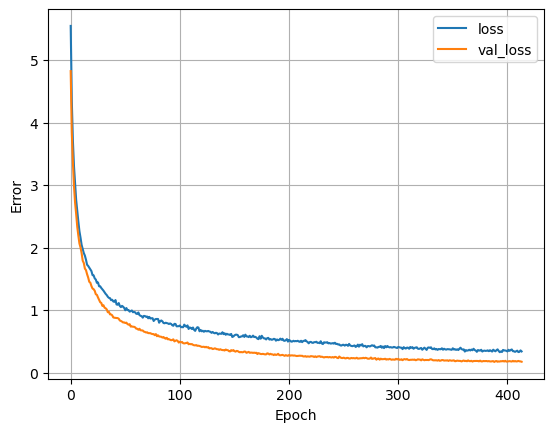

In [14]:
#########
#tsunami_bali2.save('tsunami_bali_model_051123')
####load jika tidak running####
#----#
tsunami_bali2 = tf.keras.models.load_model('tsunami_bali_model_051123')
tsunami_bali2.evaluate(x_test,[y_test1,y_test2,y_test3,y_test4,y_test5])


#
plot_loss(history)

# 5. Nilai Korelasi $R^2$ Pada Setiap Sub-Fault

In [246]:
def r_data(loc,pantai):
    #mws = np.round(np.arange(7,9.1,0.1),1)
    mws = gjl
    r2val = []
    rmseval= []
    for mw in mws:
            pred, data , time= prek(mw,loc,pantai)
            r2val.append(r_square(pred,data))
            rmseval.append(rmse_val(pred,data))
    r_avg = np.mean(r2val)
    rmse_avg = np.mean(rmseval)
    return r2val, rmseval, r_avg, rmse_avg
def r2data(loc):
    pantai = ("Tanah Lot", "Kuta", "Uluwatu", "Nusa Dua", "Sanur","Kelingking")
    rdata1 = r_data(loc,'tanahlot')[0]
    rdata2 = r_data(loc,'kuta')[0]
    rdata3 = r_data(loc,'uluwatu')[0]
    rdata4 = r_data(loc,'nusadua')[0]
    rdata5 = r_data(loc,'sanur')[0]
    rdata6 = r_data(loc,'kelingking')[0]
    rdata = pd.DataFrame([rdata1,rdata2,rdata3,rdata4,rdata5,rdata6]).transpose()
    rdata.columns= pantai
    rdata.index = gjl
    #warnings.filterwarnings("ignore", category=UserWarning)
    sns.lineplot(rdata, markers=True)
    plt.xlabel('Moment Magnitude')
    plt.ylabel('$R^2$ Value')
    plt.title('$R^2$ pada Fault : {}'.format(loc))
    plt.ylim([0.7,1])
    plt.show() 
    return 

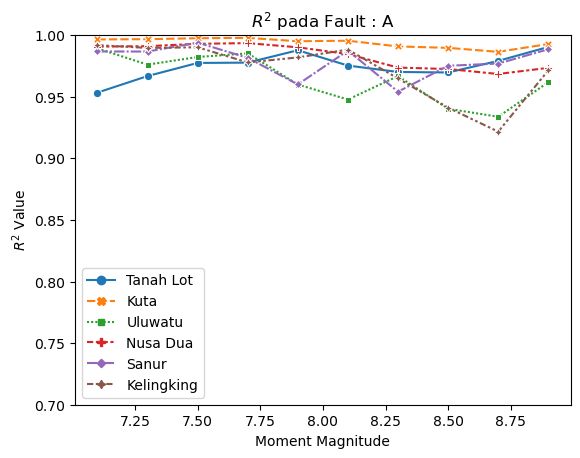

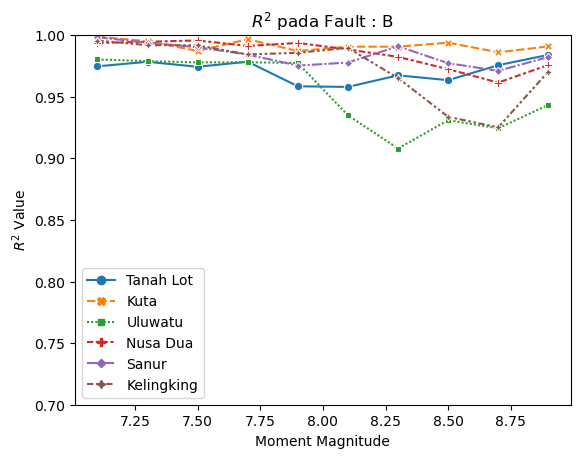

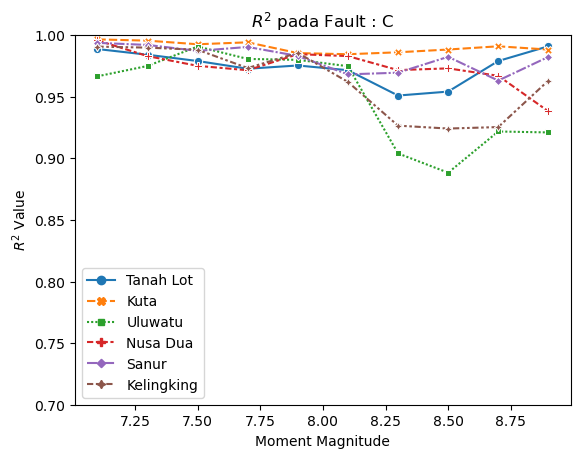

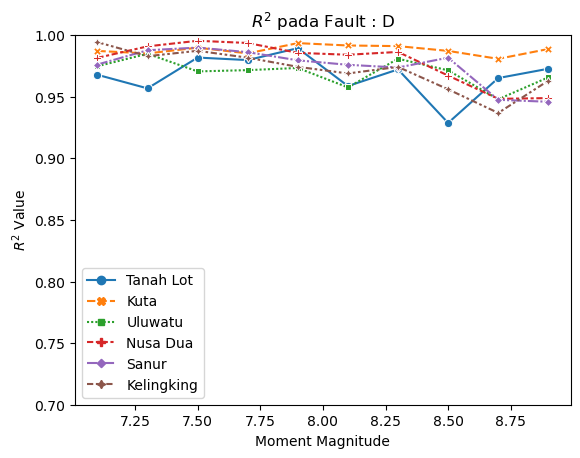

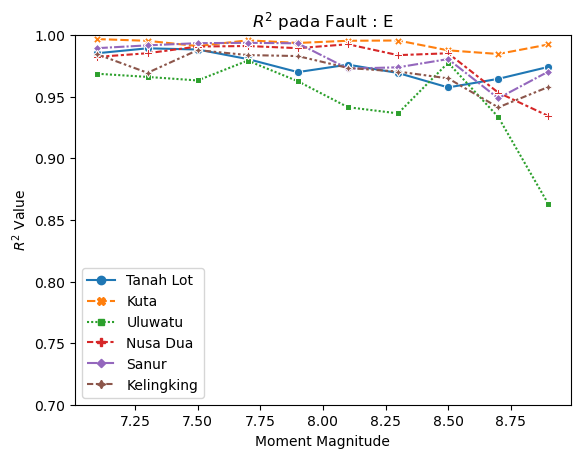

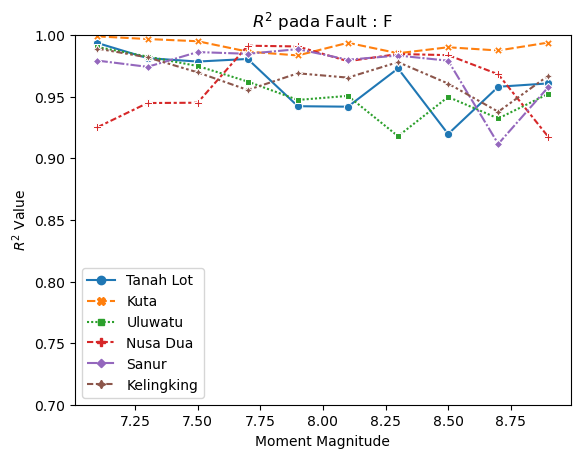

In [247]:
r2data('A')
r2data('B')
r2data('C')
r2data('D')
r2data('E')
r2data('F')

# 6. Nilai Korelasi $R^2$ Ketinggian dan Waktu Kedatangan Tsunami di Lokasi Observasi

In [17]:
def korelasi_hsl(pantai):
    maxh_all = pd.DataFrame()
    artm_all = pd.DataFrame()
    locs = ('A','B','C','D','E','F')

    for lok in locs:
        maxh, artm, r2maxh, r2arrtime = tsunami_parameter(lok,pantai)
        maxh_all = pd.concat([maxh,maxh_all])
        artm_all  = pd.concat([artm,artm_all])
    r_maxh_all = r_square(maxh_all['Numerik'],maxh_all['Prediksi'])
    r_artm_all = r_square(artm_all['Numerik'],artm_all['Prediksi'])
    return maxh_all, artm_all

def plot_kor(maxh_all, artm_all, r_maxh_all):
    sns.lmplot(data=maxh_all, x='Numerik', y='Prediksi', 
               palette='Set1')
    plt.grid()
    nama = code_pantai(pantai)
    plt.title('Ketinggian Tsunami\n$R^2$: {:.3f}, Lokasi : {}'
              .format(r_maxh_all,nama[2]),**tnrfont, size=14)
    #plt.suptitle(nama[2],**tnrfont)
    plt.xlabel('Numerik',**tnrfont)
    plt.ylabel('Prediksi',**tnrfont)
    ######################################
    sns.lmplot(data=artm_all, x='Numerik', y='Prediksi', 
               palette='Set1')
    plt.grid()
    nama = code_pantai(pantai)
    plt.title('Waktu Kedatangan Tsunami\n$R^2$: {:.3f}, Lokasi : {}'
              .format(r_artm_all,nama[2]),**tnrfont, size=14)
    #plt.suptitle(nama[2],**tnrfont)
    plt.xlabel('Numerik',**tnrfont)
    plt.ylabel('Prediksi',**tnrfont)

Text(33.37500000000001, 0.5, 'Prediksi (menit)')

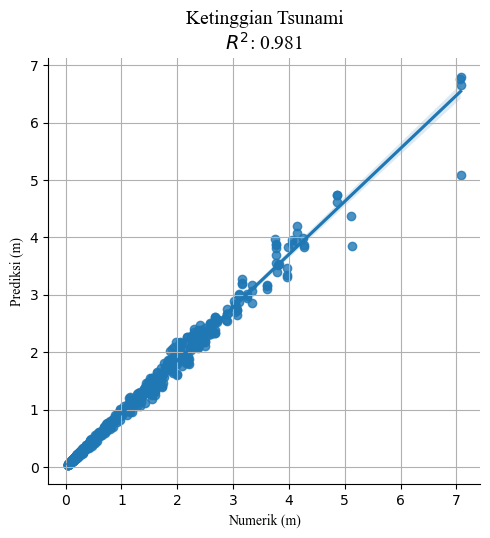

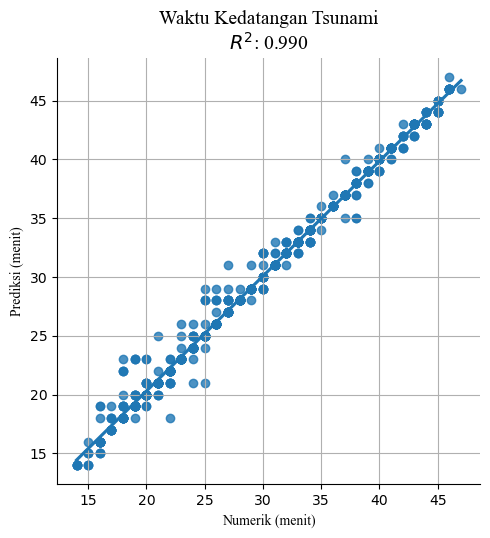

In [18]:
## PLOT SEMUA SEMUA NILAI KORELASI##
pantaig = 'tanahlot','kuta','uluwatu','nusadua','sanur','kelingking'
h_max = pd.DataFrame()
artime = pd.DataFrame()
for pnt in pantaig:
    h,tm = korelasi_hsl(pnt)
    h_max = pd.concat([h,h_max])
    artime = pd.concat([tm,artime])
r_h = r_square(h_max['Numerik'],h_max['Prediksi'])
r_tm = r_square(artime['Numerik'],artime['Prediksi'])
sns.lmplot(data=h_max, x='Numerik', y='Prediksi', 
           palette='Set1')
plt.grid()
#nama = code_pantai(pantai)
plt.title('Ketinggian Tsunami\n$R^2$: {:.3f}'
          .format(r_h),**tnrfont, size=14)
#plt.suptitle(nama[2],**tnrfont)
plt.xlabel('Numerik (m)',**tnrfont)
plt.ylabel('Prediksi (m)',**tnrfont)
######################################
sns.lmplot(data=artime, x='Numerik', y='Prediksi', 
           palette='Set1')
plt.grid()
#nama = code_pantai(pantai)
plt.title('Waktu Kedatangan Tsunami\n$R^2$: {:.3f}'
          .format(r_tm),**tnrfont, size=14)
#plt.suptitle(nama[2],**tnrfont)
plt.xlabel('Numerik (menit)',**tnrfont)
plt.ylabel('Prediksi (menit)',**tnrfont)

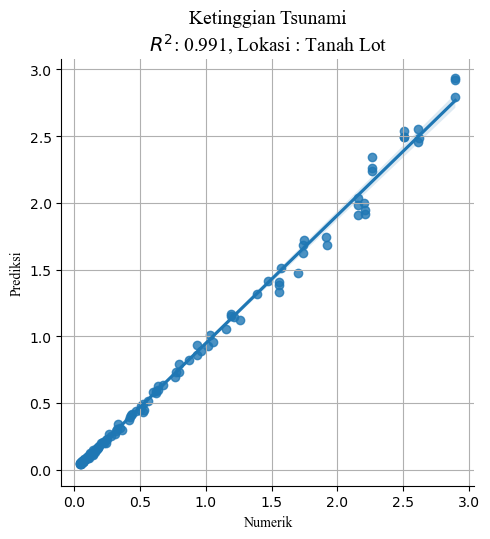

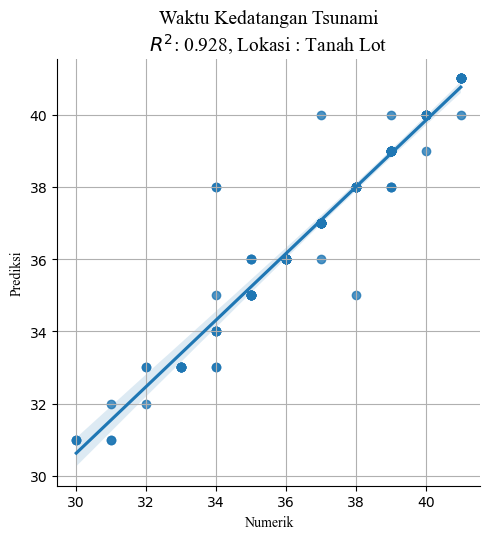

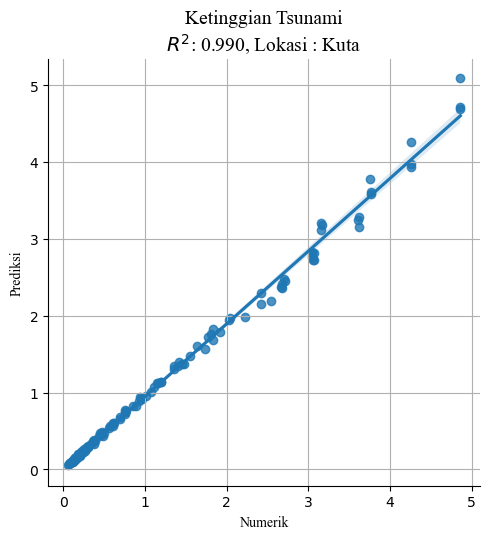

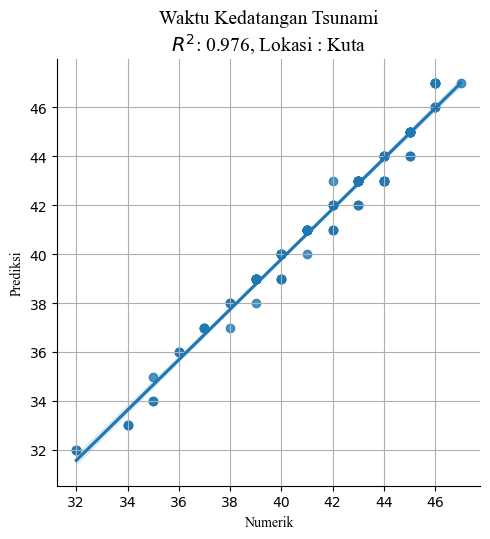

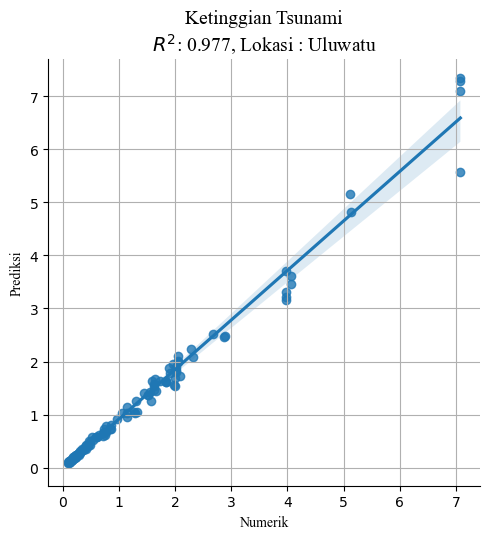

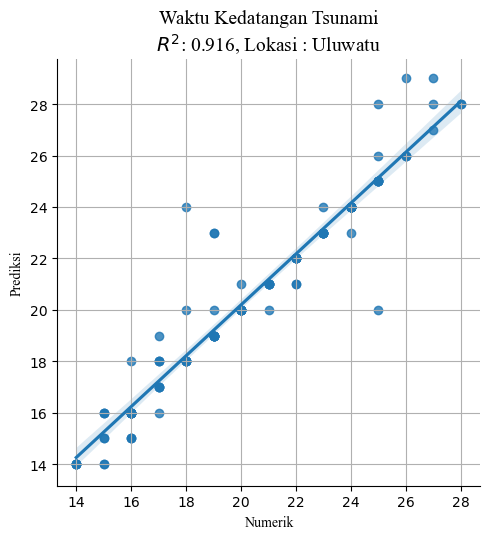

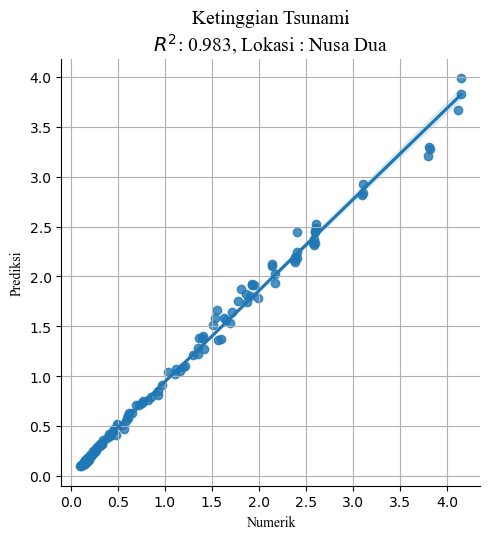

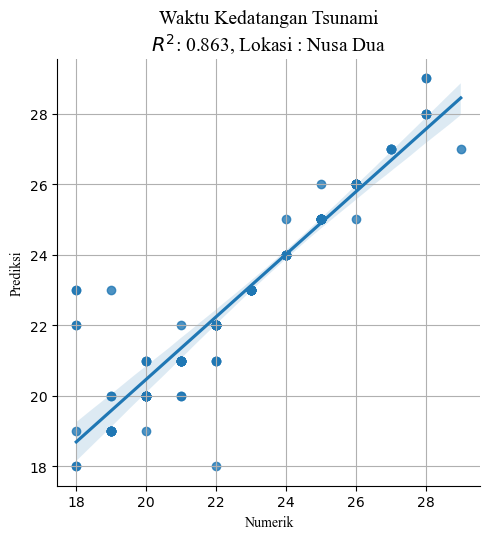

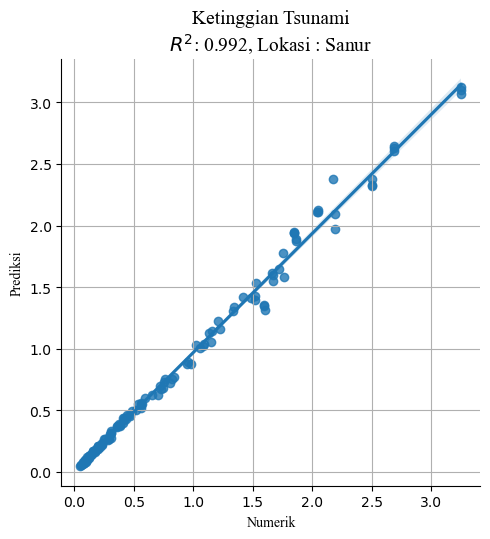

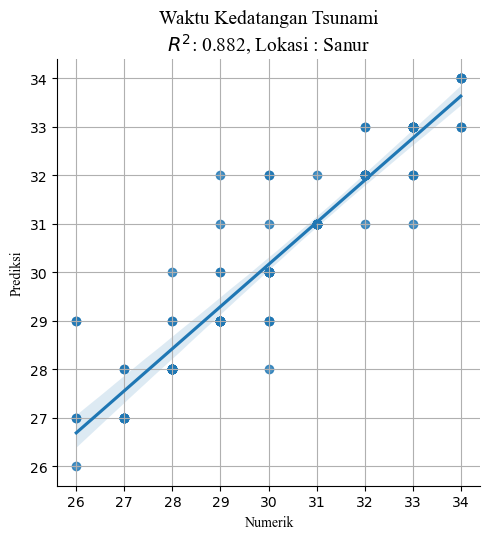

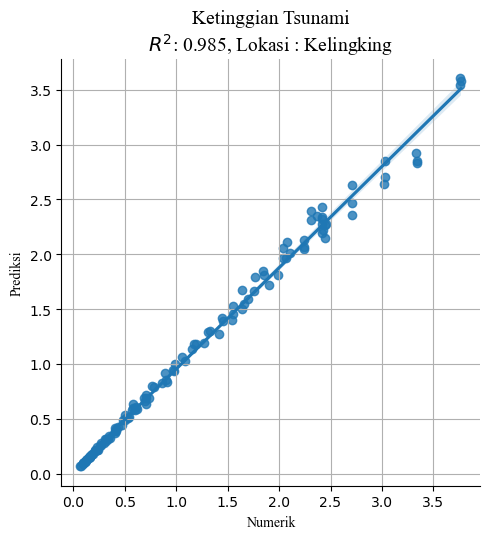

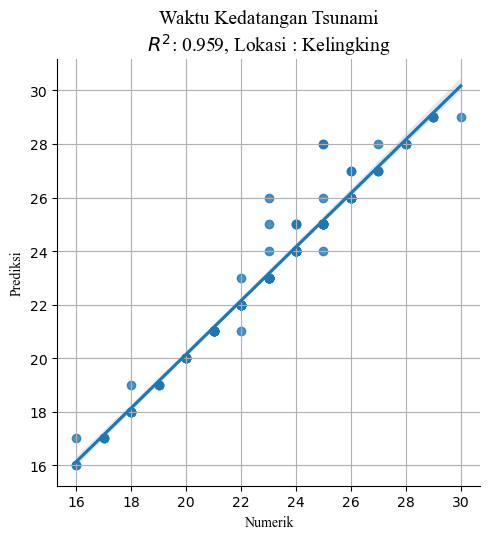

In [248]:
# KORELASI HASIL TIAP PANTAI PADA SEMUA DATA
korelasi_hasil('tanahlot')
korelasi_hasil('kuta')
korelasi_hasil('uluwatu')
korelasi_hasil('nusadua')
korelasi_hasil('sanur')
korelasi_hasil('kelingking')

In [49]:
pantai = 'uluwatu'
maxh_all = pd.DataFrame()
artm_all = pd.DataFrame()
locs = ('A','B','C','D','E','F')

for lok in locs:
    maxh, artm, r2maxh, r2arrtime = tsunami_parameter(lok,pantai)
    maxh_all = pd.concat([maxh,maxh_all])
    artm_all  = pd.concat([artm,artm_all])

In [50]:
print(maxh_all.max())
print(artm_all.max())

Numerik     7.07576
Prediksi    6.79166
dtype: float64
Numerik     28
Prediksi    29
dtype: int64


In [51]:
print(maxh_all.min())
print(artm_all.min())

Numerik     0.090906
Prediksi    0.080905
dtype: float64
Numerik     14
Prediksi    14
dtype: int64


# 7. Prediksi Tsunami, input Mw dan Lokasi sub-fault

In [175]:
def arrivaltime(h,y_data, pantai):
    x = h
    y = np.array(y_data).reshape(-1)
    #data = y[y>0.02]
    peaks, _ = find_peaks(y)
    y2 = y[peaks]
    y3 = y2[y2>0.005]
    y3[0]
    
    t = np.amax(y3[0])
    index = np.where(y==t)

    x_drop = index[0][0]
    return x_drop, x_drop

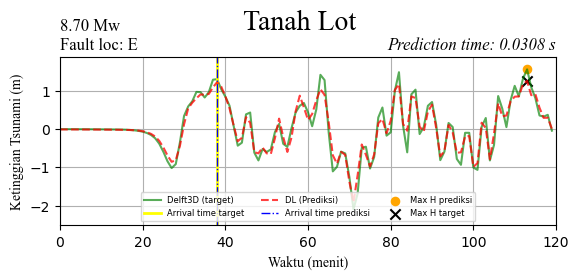

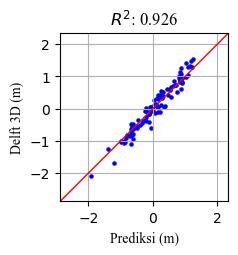

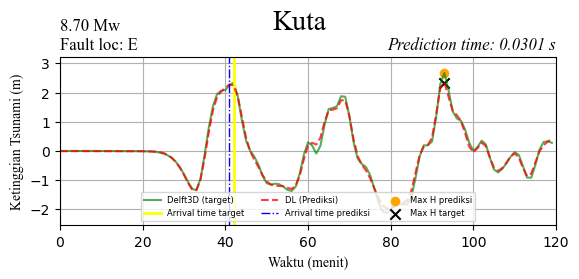

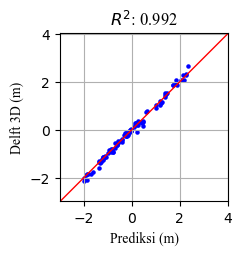

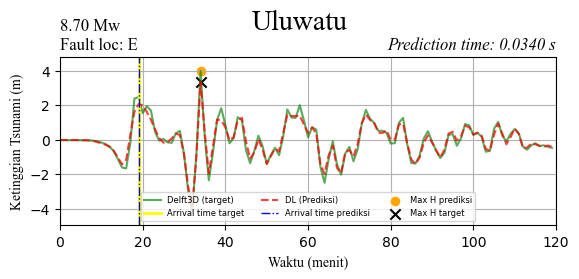

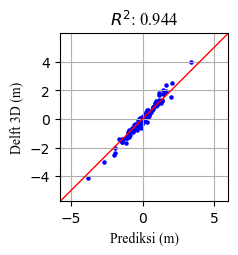

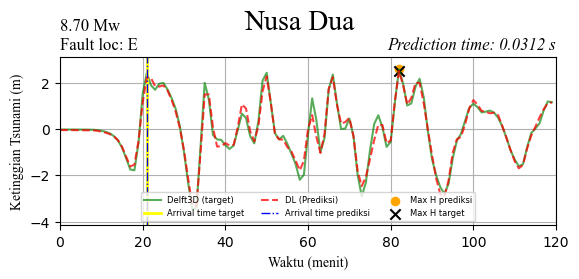

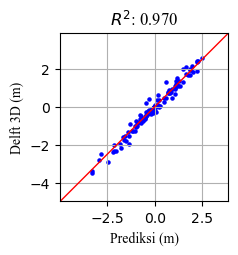

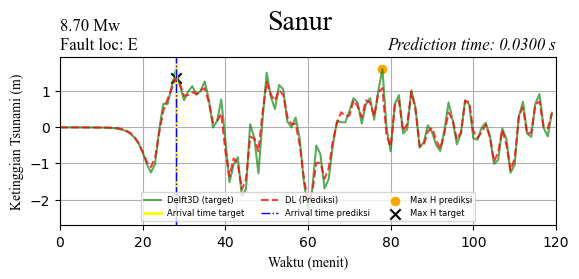

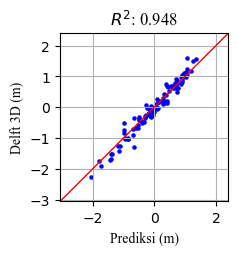

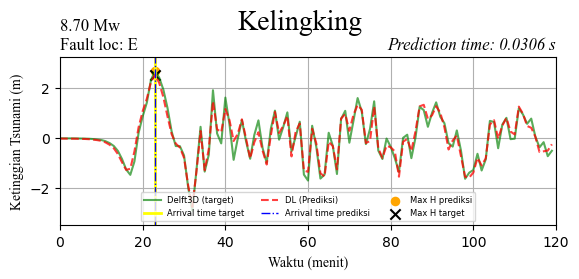

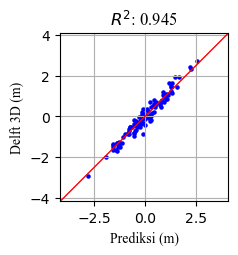

In [48]:
plot_prediksi(8.7,'E')

# ----------MENAMPILKAN HASIL DELFT 3D--------

In [234]:
def plot_delft(pantai):
    maxh_all = pd.DataFrame()
    artm_all = pd.DataFrame()
    locs = ('A','B','C','D','E','F')

    for lok in locs:
        maxh, artm, r2maxh, r2arrtime = tsunami_parameter(lok,pantai)
        maxh_all = pd.concat([maxh_all, maxh], axis=1)
        artm_all  = pd.concat([artm_all,artm],axis=1)
        #artm_all.append(maxh)
    nama = code_pantai(pantai)
    hmax = maxh_all['Numerik']
    hmax.columns = ['A','B','C','D','E','F']
    hmax
    tmax = artm_all['Numerik']
    tmax.columns = ['A','B','C','D','E','F']
    tmax
    df = pd.melt(hmax)
    df.index = xdatabase.index
    df.columns = ['Sub-fault','data']
    sns.barplot(data = df, x=df.index, y='data', hue='Sub-fault', palette=sns.color_palette("magma"))
    plt.ylim(0,7.5)
    plt.xlabel('Magnitudo (Mw)', **tnrfont)
    plt.ylabel('Ketinggian Maksimum (m)', **tnrfont)
    plt.title('Ketinggian Maksimum Tsunami di Pantai {}'
              .format(nama[2]),**tnrfont, size=14)
    plt.grid(linewidth=0.5, alpha=0.5)
    plt.show()
    ##############################

    tf = pd.melt(tmax)
    tf.index = xdatabase.index
    tf.columns = ['Sub-fault','data']
    sns.barplot(data = tf, x=tf.index, y='data', hue='Sub-fault', palette=sns.color_palette("viridis"))
    plt.xlabel('Magnitudo (Mw)', **tnrfont)
    plt.ylabel('Waktu Tiba (menit)', **tnrfont)
    plt.title('Waktu Tiba Tsunami di Pantai {}'
              .format(nama[2]),**tnrfont, size=14)
    miny = np.amin(np.array(artm_all))
    plt.legend(ncol=6, loc=9)
    
    plt.ylim(0,50)
    plt.grid(linewidth=0.5, alpha=0.5)
    plt.show()
    return
def plot_data_asli(Mw_prediksi, loc, pantai):
    h = np.arange(0,120)
    #arrival time tsunami
    pred, data, time = prek(Mw_prediksi, loc, pantai)
    ar_data, ar_y2 = arrivaltime(h,data, pantai)
    xdata, maxdata = max_height(h,data,ar_data)
    maxdata = np.round(maxdata,2)
    #plot
    plt.plot(h,data, color='blue', alpha=0.75 ,linestyle='-', lw=1.5)
    plt.scatter(ar_data, data[ar_y2],marker=7, s=35, color='red')
    plt.scatter(xdata,data[xdata],marker="x", s=55, color='black')
    plt.grid()
    plt.xlabel('Waktu (menit)',**tnrfont)
    plt.ylabel('Ketinggian Tsunami (m)',**tnrfont)
    #Plotting
    plt.xlim(0,120)
    minval1=min(data)
    maxval1=max(data)
    plt.ylim(minval1+minval1/5, maxval1+maxval1/5)
    #plt.ylim(-2.5,2.5)
    
    plt.legend(['Ketinggian tsunami','Arrival time',
               'Ketinggian Maksimum'],
               fontsize=6,ncol=1, loc=8)
    plt.suptitle(code_pantai(pantai)[2], fontsize=20,**tnrfont)
    
    plt.title('{:.2f} Mw \nFault loc: {}'.format(Mw_prediksi,loc),loc='left',**tnrfont)
    plt.title("H Maks: {} m\nWaktu Tiba: {} menit"
              .format(maxdata[0], ar_data)
              ,loc='right',**tnrfont,
             fontstyle="italic")
    plt.show()
    return maxdata, ar_data

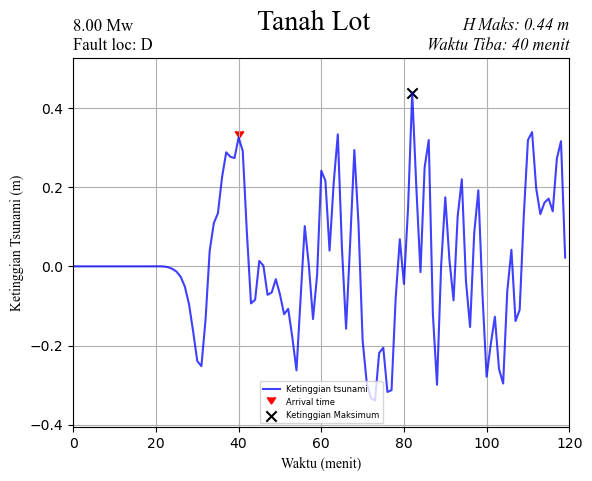

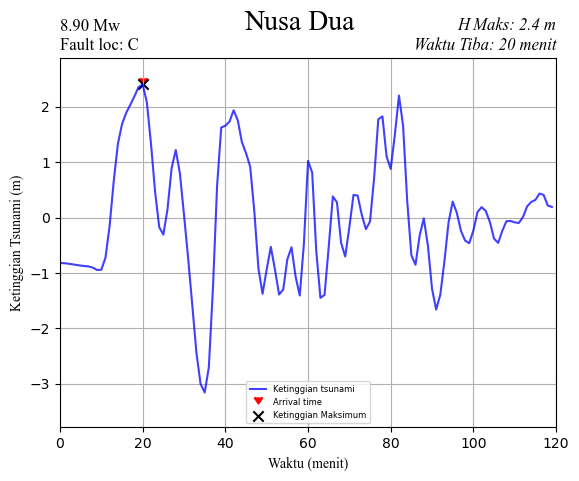

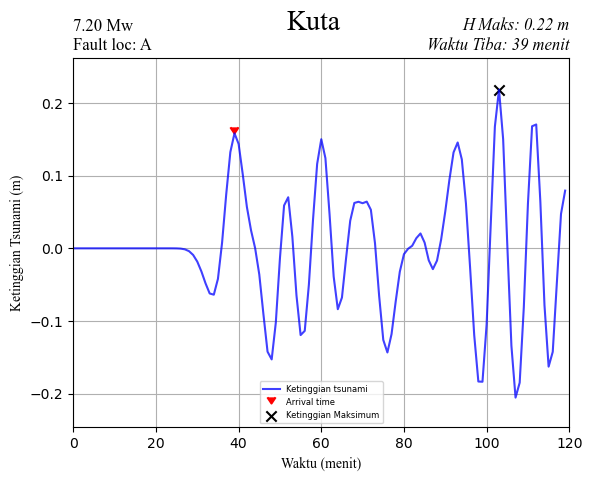

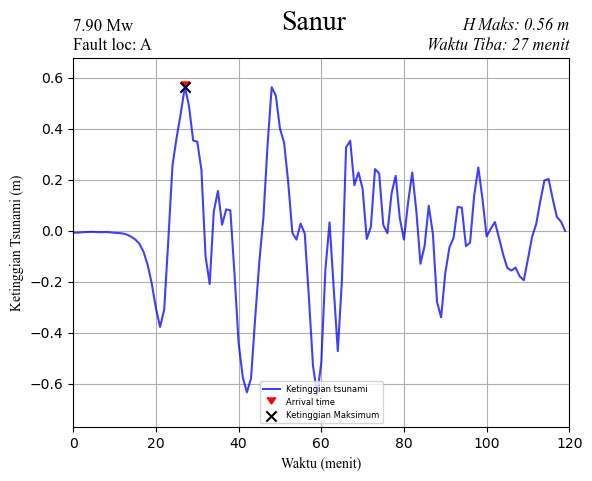

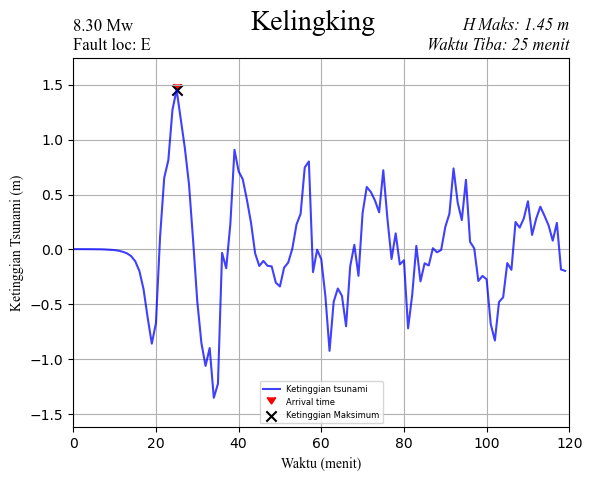

(array([1.45]), 25)

In [173]:
plot_data_asli(8,'D','tanahlot')
plot_data_asli(8.9,'C','nusadua')
plot_data_asli(7.2,'A','kuta')
plot_data_asli(7.9,'A','sanur')
plot_data_asli(8.3,'E','kelingking')

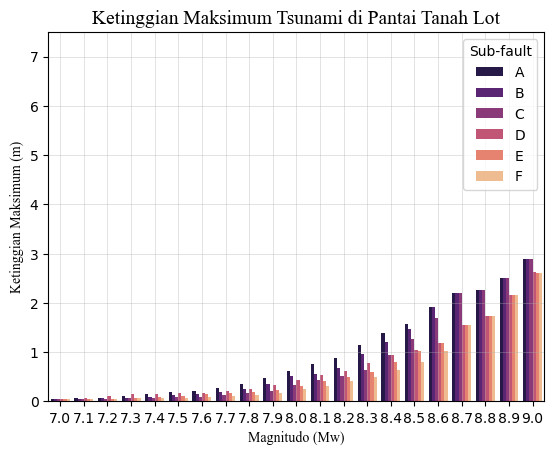

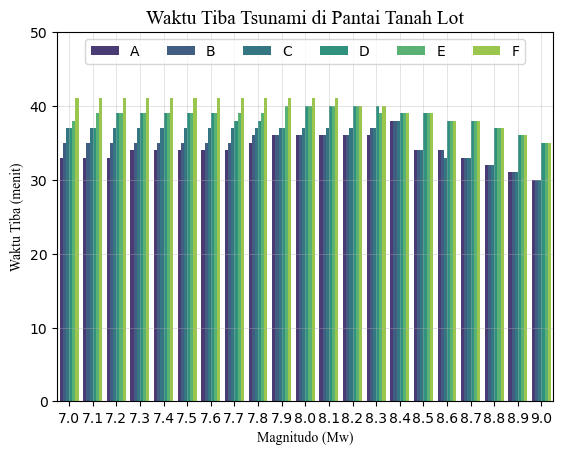

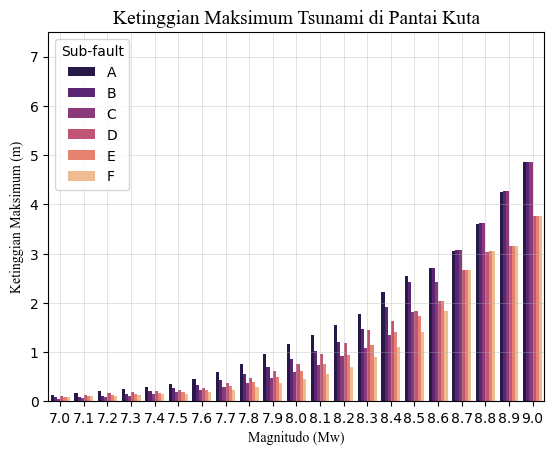

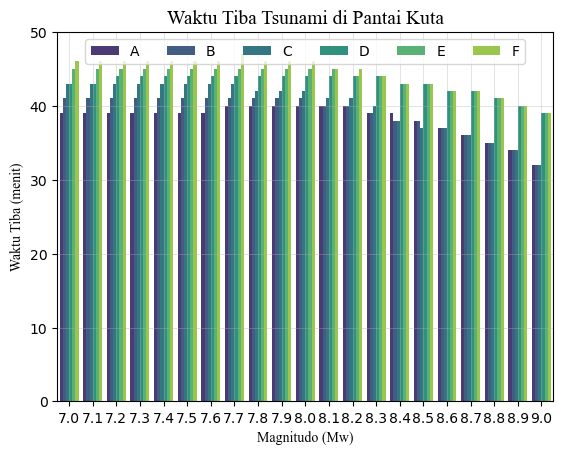

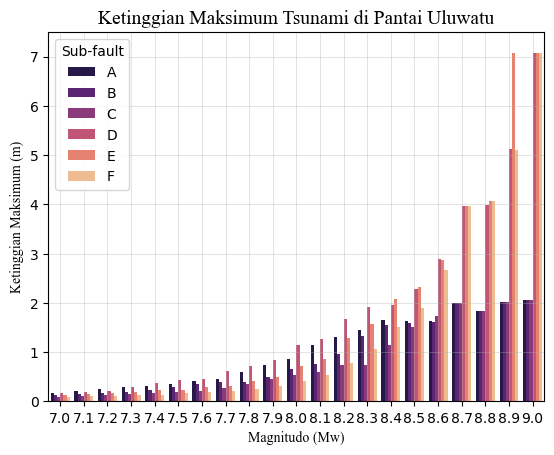

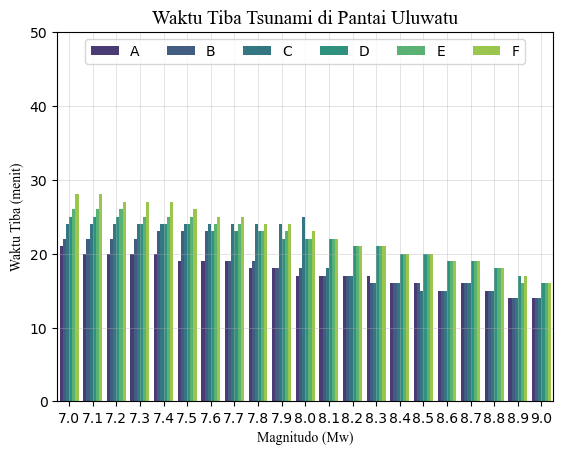

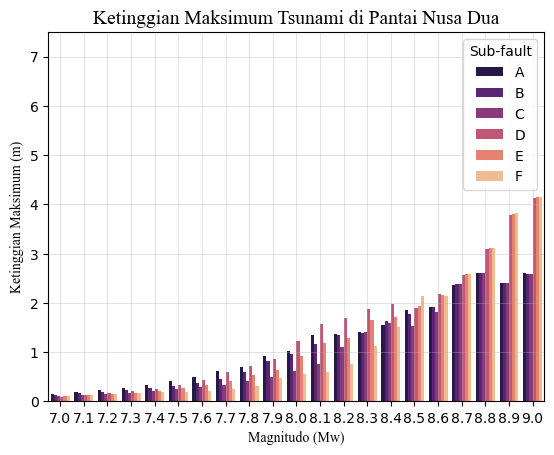

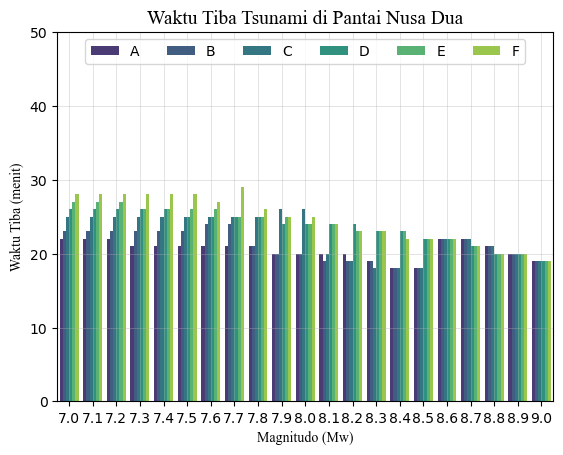

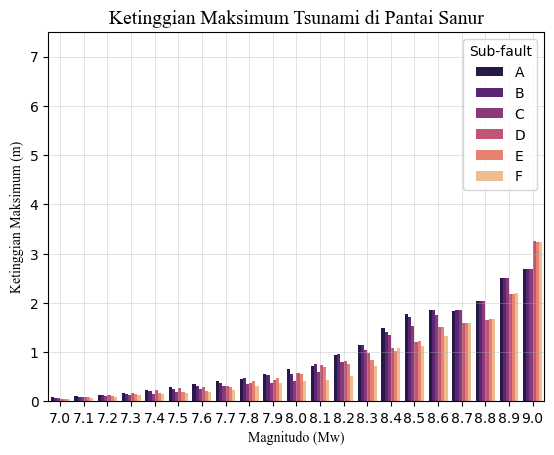

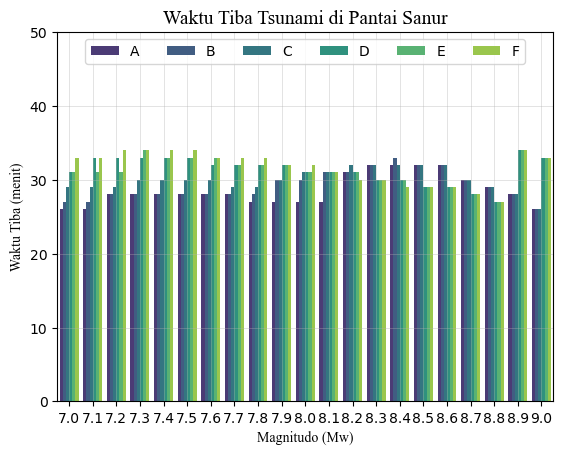

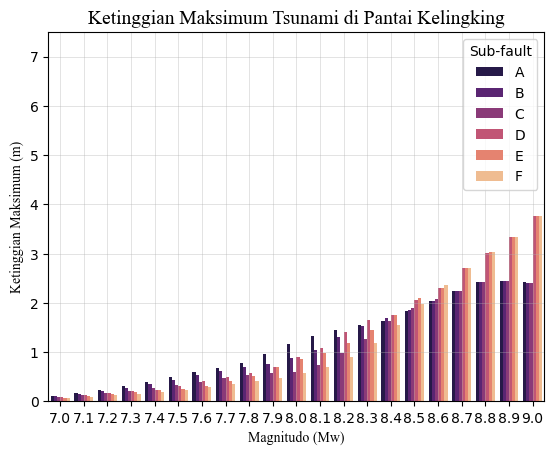

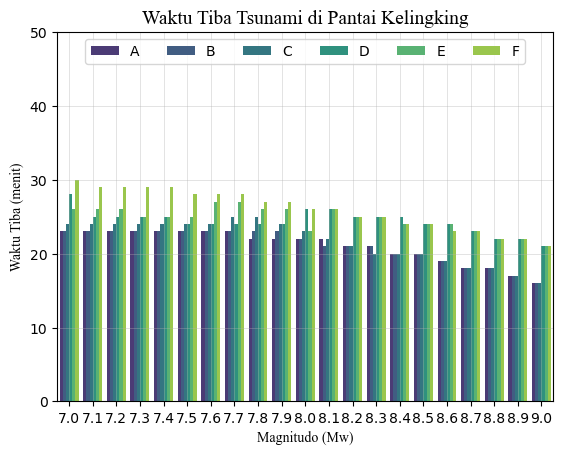

In [235]:
plot_delft('tanahlot')
plot_delft('kuta')
plot_delft('uluwatu')
plot_delft('nusadua')
plot_delft('sanur')
plot_delft('kelingking')